<a href="https://colab.research.google.com/github/VictorV1ana/fincrime/blob/main/fincrime_note.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Trade Republic Data Science - FinCrime
<p align="center">
  <img src="https://raw.githubusercontent.com/VictorV1ana/fincrime/5faf632aa96f851f3d23ee35730fdddd938215da/trade-republic3424.jpg" width="60%">
</p>


## Imports and Configs

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from warnings import simplefilter
simplefilter(action="ignore", category= FutureWarning)

In [3]:
from sklearn.model_selection import cross_val_predict
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, IsolationForest
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import precision_score, recall_score
from sklearn.svm import OneClassSVM
from sklearn.model_selection import train_test_split


In [4]:
from sklearn.impute import SimpleImputer
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import OneHotEncoder

In [5]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
import matplotlib.pyplot as plt

In [6]:
from sklearn.preprocessing import StandardScaler

In [7]:
from imblearn.under_sampling import RandomUnderSampler

In [8]:
import joblib
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from imblearn.under_sampling import RandomUnderSampler

In [9]:
pd.set_option('display.max_columns', None)

## Support Classes

### Data Engeneering Classes and Functions

In [10]:
class DataTransformer:
    def __init__(self, input_df):
        self.df = input_df.copy()
        self.fraud_df, self.regular_df, self.dist_fraud_df, self.dist_legit_df, self.df = self.generate_new_dfs()
        """
        Initializes the DataTransformer instance.

        Parameters:
        - input_df (pd.DataFrame): Input DataFrame containing transaction data.
        """

    def get_fraud_df(self):
        return self.fraud_df

    def get_regular_df(self):
        return self.regular_df

    def get_dist_fraud_df(self):
        return self.dist_fraud_df

    def get_dist_legit_df(self):
        return self.dist_legit_df

    def get_df(self):
        return self.df


    def generate_new_dfs(self):
        """
        Generates new DataFrames based on fraud and regular transactions.

        Returns:
        - fraud_df: DataFrame containing fraud transactions.
        - regular_df: DataFrame containing regular (non-fraud) transactions.
        - dist_fraud_df: DataFrame containing distributed fraud transactions.
        - dist_legit_df: DataFrame containing distributed regular (non-fraud) transactions.
        - df: Original DataFrame.
        """
        fraud_df = self.df[self.df.is_fraud == 1]
        regular_df = self.df[self.df.is_fraud == 0]
        dist_fraud_df = self.df[self.df['is_fraud'] == 1]
        dist_legit_df = self.df[self.df['is_fraud'] == 0].sample(dist_fraud_df.shape[0], random_state=42)
        return fraud_df, regular_df, dist_fraud_df, dist_legit_df, self.df

    def create_time_features(self, input_df):
        """
        Creates time-related features.

        Parameters:
        - input_df (pd.DataFrame): Input DataFrame.

        Returns:
        - df (pd.DataFrame): DataFrame with added time features.
        """
        df = input_df.copy()
        df.rename(columns={'trans_date_trans_time': 'datetime'}, inplace=True)
        df['datetime'] = pd.to_datetime(df['datetime'])
        df['dob'] = pd.to_datetime(df['dob'])
        df['date'] = pd.to_datetime(df['datetime']).dt.date
        df['hour'] = pd.to_datetime(df['datetime']).dt.hour
        df['day_of_week'] = pd.to_datetime(df['datetime']).dt.dayofweek
        df['day'] = pd.to_datetime(df['datetime']).dt.day
        df['month_year'] = df['datetime'].dt.strftime('%m-%Y')
        df['age'] = df['datetime'].dt.year - df['dob'].dt.year
        df = df.sort_values(by=['cc_num', 'datetime'])
        df['hours_since_previous_transaction'] = df.groupby('cc_num')['datetime'].diff().dt.total_seconds() / 3600
        df['minutes_since_previous_transaction'] = df.groupby('cc_num')['datetime'].diff().dt.total_seconds() / 60

        return df

    def create_amount_diff_features(self, input_df):
        """
        Creates features based on transaction amount differences.

        Parameters:
        - input_df (pd.DataFrame): Input DataFrame.

        Returns:
        - df (pd.DataFrame): DataFrame with added amount difference features.
        """
        df = input_df.copy()
        df = df.sort_values(by=['datetime', 'cc_num'])
        df['amt_diff'] = df.groupby('cc_num')['amt'].diff()
        return df

    def create_amount_deviation_features(self, input_df):
        """
        Creates features based on transaction amount deviations.

        Parameters:
        - input_df (pd.DataFrame): Input DataFrame.

        Returns:
        - df (pd.DataFrame): DataFrame with added amount deviation features.
        """
        df = input_df.copy()
        df['historical_mean_amount'] = df.groupby('cc_num')['amt'].expanding().mean().reset_index(level=0, drop=True)
        df['historical_median_amount'] = df.groupby('cc_num')['amt'].expanding().median().reset_index(level=0, drop=True)
        df['amount_deviation_from_mean'] = df['amt'] - df['historical_mean_amount']
        df['amount_deviation_from_median'] = df['amt'] - df['historical_median_amount']
        df['hour_mean_amount'] = df.groupby('hour')['amt'].transform('mean')
        df['hour_median_amount'] = df.groupby('hour')['amt'].transform('median')
        df['amount_deviation_from_hour_mean'] = df['amt'] - df['hour_mean_amount']
        df['amount_deviation_from_hour_median'] = df['amt'] - df['hour_median_amount']
        df['lat_long_delta_merchant_customer'] = np.sqrt((df['lat'] - df['merch_lat'])**2 + (df['long'] - df['merch_long'])**2)
        return df

    def create_location_features(self, input_df):
        df = input_df.copy()
        region_mapping = {
            'northeast': ['CT', 'ME', 'MA', 'NH', 'RI', 'VT', 'NY', 'NJ', 'PA'],
            'south': ['DE', 'FL', 'GA', 'MD', 'NC', 'SC', 'VA', 'WV', 'DC'],
            'midwest': ['IL', 'IN', 'IA', 'KS', 'MI', 'MN', 'MO', 'NE', 'ND', 'OH', 'SD', 'WI'],
            'west': ['AZ', 'CO', 'ID', 'MT', 'NV', 'NM', 'UT', 'WY', 'AK', 'CA', 'HI', 'OR', 'WA']
        }

        def map_state_to_region(state):
            for region, states in region_mapping.items():
                if state in states:
                    return region
            return 'Unknown'

        df['region'] = df['state'].apply(map_state_to_region)
        df['amount_to_city_pop_ratio'] = df['amt'] / df['city_pop']
        return df

    def run_pipeline(self, input_df):

        aux = input_df.copy()
        aux = self.create_time_features(aux)
        aux = self.create_amount_diff_features(aux)
        aux = self.create_amount_deviation_features(aux)
        aux = self.create_location_features(aux)

        return aux

    def run_pipeline_for_all_dfs(self):
            dfs_to_process = [self.fraud_df, self.regular_df, self.dist_fraud_df, self.dist_legit_df, self.df]
            processed_dfs = []

            for df in dfs_to_process:
                processed_df = self.run_pipeline(df)
                processed_dfs.append(processed_df)

            return processed_dfs


In [11]:
def align_and_fill_columns(df, reference_df, value=0):
    """
    Aligns and fills missing columns in the DataFrame.

    Parameters:
    - df (pd.DataFrame): Input DataFrame.
    - reference_df (pd.DataFrame): Reference DataFrame for column alignment.
    - value (int or float): Value used to fill missing entries.

    Returns:
    - df (pd.DataFrame): DataFrame with aligned and filled columns.
    """
    ordered_columns = reference_df.columns
    df = df.reindex(columns=ordered_columns, fill_value=value)

    missing_columns = reference_df.columns.difference(df.columns)
    for column in missing_columns:
        df[column] = value

    return df

def preprocess_train_data(df, features):
    """
    Preprocesses training data, including resampling, imputation, scaling, and encoding.

    Parameters:
    - df (pd.DataFrame): Input DataFrame containing training data.
    - features (list): List of feature columns.

    Returns:
    - df_resampled_onehot (pd.DataFrame): Processed DataFrame with resampled, imputed, scaled, and encoded features.
    - X (pd.DataFrame): Features after preprocessing.
    - y (pd.Series): Target variable after preprocessing.
    """
    # Separate features and target columns
    X = df[features]
    y = df['is_fraud']

    # Undersample the training data
    undersampler = RandomUnderSampler(sampling_strategy=1, random_state=42)
    X_resampled, y_resampled = undersampler.fit_resample(X, y)

    # Create a DataFrame with resampled data
    df_resampled = pd.concat([pd.DataFrame(X_resampled, columns=X.columns), pd.Series(y_resampled, name='is_fraud')], axis=1)

    # Separate numeric and categorical features
    numeric_features = df_resampled.select_dtypes(include=np.number).columns
    numeric_features = numeric_features.drop('is_fraud', errors='ignore')
    categorical_features = df_resampled.select_dtypes(exclude=np.number).columns

    # Create imputer for numeric values (median)
    numeric_imputer = SimpleImputer(strategy='median')
    df_resampled[numeric_features] = numeric_imputer.fit_transform(df_resampled[numeric_features])

    # Apply Standard Scaler to numeric columns
    scaler = StandardScaler()
    df_resampled[numeric_features] = scaler.fit_transform(df_resampled[numeric_features])
    joblib.dump(scaler, 'scaler_model.joblib')

    # Create imputer for categorical values (most frequent)
    categorical_imputer = SimpleImputer(strategy='most_frequent')
    df_resampled[categorical_features] = categorical_imputer.fit_transform(df_resampled[categorical_features])

    # Apply one-hot encoding to categorical columns, excluding 'datetime'
    onehot_features = [col for col in categorical_features if col != 'datetime']
    encoder = OneHotEncoder(drop='first', sparse=False)

    # Fit and transform the data, then create a DataFrame with the new columns
    onehot_encoded = encoder.fit_transform(df_resampled[onehot_features])
    new_columns = encoder.get_feature_names_out(onehot_features)
    df_resampled_onehot = pd.concat([df_resampled, pd.DataFrame(onehot_encoded, columns=new_columns)], axis=1)

    # Drop the original categorical columns and update column names
    df_resampled_onehot.drop(columns=onehot_features, inplace=True)
    df_resampled_onehot.columns = df_resampled_onehot.columns.str.lower().str.replace(' ', '_')
    df_resampled_onehot.columns = df_resampled_onehot.columns.str.lower().str.replace('-', '_')

    # Separate X and y
    X = df_resampled_onehot.drop(columns=['is_fraud', 'datetime'], axis=1)
    y = df_resampled_onehot['is_fraud']

    return df_resampled_onehot, X, y

def preprocess_test_data(df, features, x_train_processed=None, scaler_model_path='scaler_model.joblib'):
    """
    Preprocesses test data, including imputation, scaling, and encoding.

    Parameters:
    - df (pd.DataFrame): Input DataFrame containing test data.
    - features (list): List of feature columns.
    - x_train_processed (pd.DataFrame): Processed training data (optional).
    - scaler_model_path (str): Path to the scaler model file.

    Returns:
    - df (pd.DataFrame): Processed DataFrame with imputed, scaled, and encoded features.
    - X (pd.DataFrame): Features after preprocessing.
    - y (pd.Series): Target variable.
    """
    # Separate features and target columns
    X = df[features]
    y = df['is_fraud']

    # Separate numeric and categorical features
    numeric_features = X.select_dtypes(include=np.number).columns
    numeric_features = numeric_features.drop('is_fraud', errors='ignore')
    categorical_features = X.select_dtypes(exclude=np.number).columns

    # Create imputer for numeric values (median)
    numeric_imputer = SimpleImputer(strategy='median')
    X.loc[:, numeric_features] = numeric_imputer.fit_transform(X.loc[:, numeric_features])

    # Apply Standard Scaler to numeric columns
    scaler = joblib.load(scaler_model_path)
    X.loc[:, numeric_features] = scaler.transform(X.loc[:, numeric_features])

    # Create imputer for categorical values (most frequent)
    categorical_imputer = SimpleImputer(strategy='most_frequent')
    X.loc[:, categorical_features] = categorical_imputer.fit_transform(X.loc[:, categorical_features])

    # Apply one-hot encoding to categorical columns, excluding 'datetime'
    onehot_features = [col for col in categorical_features if col != 'datetime']
    encoder = OneHotEncoder(drop='first', sparse=False)

    # Fit and transform the data, then create a DataFrame with the new columns
    onehot_encoded = encoder.fit_transform(X[onehot_features])
    new_columns = encoder.get_feature_names_out(onehot_features)
    X = pd.concat([X, pd.DataFrame(onehot_encoded, columns=new_columns)], axis=1)

    # Drop the original categorical columns and update column names
    X.drop(columns=onehot_features, inplace=True)
    X.columns = X.columns.str.lower().str.replace(' ', '_')
    X.columns = X.columns.str.lower().str.replace('-', '_')

    # Separate X and y
    X = X.drop(columns=['datetime'], axis=1)
    X = align_and_fill_columns(X, x_train_processed)
    y = df['is_fraud']

    df = pd.concat([X, y], axis=1)

    return df, X, y


### Visualization Class

In [12]:
class Visualization:
    def plot_fraud_comparison(self, df, time_column, fraud_color='#F8766D', regular_color='#00BFC4'):
        df_fraud_0 = df[df['is_fraud'] == 0]
        df_fraud_1 = df[df['is_fraud'] == 1]

        transactions_over_time_0 = df_fraud_0.groupby(df_fraud_0[time_column]).size().sort_index()
        transactions_over_time_1 = df_fraud_1.groupby(df_fraud_1[time_column]).size().sort_index()

        # Create bar plot
        plt.figure(figsize=(14, 5))

        # Plot for is_fraud = 0
        bar_plot_0 = sns.barplot(x=transactions_over_time_0.index, y=transactions_over_time_0, color=regular_color)
        plt.title('Volume of Regular Transactions (is_fraud = 0)', loc='left')
        plt.xlabel(time_column)
        plt.ylabel('Number of Transactions')
        sns.despine(left=True)

        # Add labels of values above the bars in black
        for p in bar_plot_0.patches:
            bar_plot_0.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='bottom', color='black', fontsize=8)

        plt.gcf().set_dpi(150)
        plt.show()

        # Plot for is_fraud = 1
        plt.figure(figsize=(14, 5))
        bar_plot_1 = sns.barplot(x=transactions_over_time_1.index, y=transactions_over_time_1, color=fraud_color)
        plt.title('Volume of Fraud Transactions (is_fraud = 1)', loc='left')
        plt.xlabel(time_column)
        plt.ylabel('Number of Transactions')
        sns.despine(left=True)

        # Add labels of values above the bars in black
        for p in bar_plot_1.patches:
            bar_plot_1.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='bottom', color='black', fontsize=8)

        plt.gcf().set_dpi(150)
        plt.show()

    def plot_time_comparison(self, df, time_column, fraud_color='#F8766D', regular_color='#00BFC4'):
        # Separate the DataFrame for is_fraud = 0 and is_fraud = 1
        df_fraud_0 = df[df['is_fraud'] == 0]
        df_fraud_1 = df[df['is_fraud'] == 1]

        # Count the number of transactions per month-year for is_fraud = 0 and is_fraud = 1
        transactions_per_month_year_0 = df_fraud_0.groupby(df_fraud_0[time_column]).size().sort_index()
        transactions_per_month_year_1 = df_fraud_1.groupby(df_fraud_1[time_column]).size().sort_index()

        # Create separate bar plots
        plt.figure(figsize=(8,6))

        # Plot for is_fraud = 0
        plt.subplot(2, 1, 1)
        bar_plot_0 = sns.barplot(x=transactions_per_month_year_0.index, y=transactions_per_month_year_0, color=regular_color)
        plt.title('Volume of Regular Transaction', loc='left', fontsize=9)
        plt.xlabel(time_column, fontsize=7)
        plt.ylabel('')
        plt.yticks(fontsize=7)
        plt.xticks(rotation=45, ha='right', fontsize=7)  # Rotate x-axis labels
        sns.despine(left=True)  # Remove left border

        # Add labels of values above the bars in gray
        for p in bar_plot_0.patches:
            bar_plot_0.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='bottom', color='black', fontsize=6)

        plt.gcf().set_dpi(150)

        # Plot for is_fraud = 1
        plt.subplot(2, 1, 2)
        bar_plot_1 = sns.barplot(x=transactions_per_month_year_1.index, y=transactions_per_month_year_1, color=fraud_color)
        plt.title('Volume of Fraud Transactions', loc='left', fontsize=9)
        plt.xlabel(time_column, fontsize=7)
        plt.ylabel('')
        plt.yticks(fontsize=7)
        plt.xticks(rotation=45, ha='right', fontsize=7)  # Rotate x-axis labels
        sns.despine(left=True)  # Remove left border

        # Add labels of values above the bars in gray
        for p in bar_plot_1.patches:
            bar_plot_1.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='bottom', color='black', fontsize=6)

        plt.gcf().set_dpi(150)

        # Display the plots
        plt.tight_layout()
        plt.show()

## Data Summary & Prep

In [13]:
df = pd.read_csv("/content/drive/MyDrive/fincrime_ds/tr_fincrime_train.csv")

In [14]:
df.head()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,state,zip,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,NC,28654,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0
1,1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,WA,99160,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0
2,2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,Malad City,ID,83252,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0
3,3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,Boulder,MT,59632,46.2306,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0
4,4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,Doe Hill,VA,24433,38.4207,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1296675 entries, 0 to 1296674
Data columns (total 23 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   Unnamed: 0             1296675 non-null  int64  
 1   trans_date_trans_time  1296675 non-null  object 
 2   cc_num                 1296675 non-null  int64  
 3   merchant               1296675 non-null  object 
 4   category               1296675 non-null  object 
 5   amt                    1296675 non-null  float64
 6   first                  1296675 non-null  object 
 7   last                   1296675 non-null  object 
 8   gender                 1296675 non-null  object 
 9   street                 1296675 non-null  object 
 10  city                   1296675 non-null  object 
 11  state                  1296675 non-null  object 
 12  zip                    1296675 non-null  int64  
 13  lat                    1296675 non-null  float64
 14  long              

In [16]:
df.isna().sum()

Unnamed: 0               0
trans_date_trans_time    0
cc_num                   0
merchant                 0
category                 0
amt                      0
first                    0
last                     0
gender                   0
street                   0
city                     0
state                    0
zip                      0
lat                      0
long                     0
city_pop                 0
job                      0
dob                      0
trans_num                0
unix_time                0
merch_lat                0
merch_long               0
is_fraud                 0
dtype: int64

In [17]:
# Generate analysis dataframes
data_transformer = DataTransformer(df)

processed_dfs = data_transformer.run_pipeline_for_all_dfs()

fraud_df, regular_df, dist_fraud_df, dist_legit_df, df = processed_dfs

## Data Analysis

1. The analysis will be conducted by going through each individual variable and its combinations with other variables from the same dataset.

2. Analytical comments are provided at the beginning and end of each section, and data visualizations are included within. If more specific commentary is required, it will be provided below the relevant visualization.

3. For the purpose of simplification, variables that did not contribute value to fraud understanding will not be displayed.

> **The analysis highlights, with the most significant business applications, are in the following sections: hour, time since last transaction, account number, category,gender and amount (amt).**





### Transaction DateTime


In [18]:
viz = Visualization()

In [19]:
print(f"Data is from {min(df['datetime'] )} to {max(df['datetime'] )}")

Data is from 2019-01-01 00:00:18 to 2020-06-21 12:13:37


### Historical / Time Series Fraud
The first thing a fraud team needs to monitor and analyze is the evolution of fraud during the time. ***But normally absolute numbers do not generate that much information***, for example, if the company is growing naturaly that willbe more frauds just beacuse there are more transactions not because the defenses mecanisms are not working.

For this reason ***we want to observe the percentage of transactions that are fraudulent over time***. The ideia is have the least realtive amount of transactions being fraud.

***In this case there is a large decline until July 2019. Then there is a pattern of two months of increase followed by a new two months drop.***

**One hypothesis for this behavior is the decline of fraud identification mechanisms over time**. Followed by a new update in two months that is make frauds decrease again.

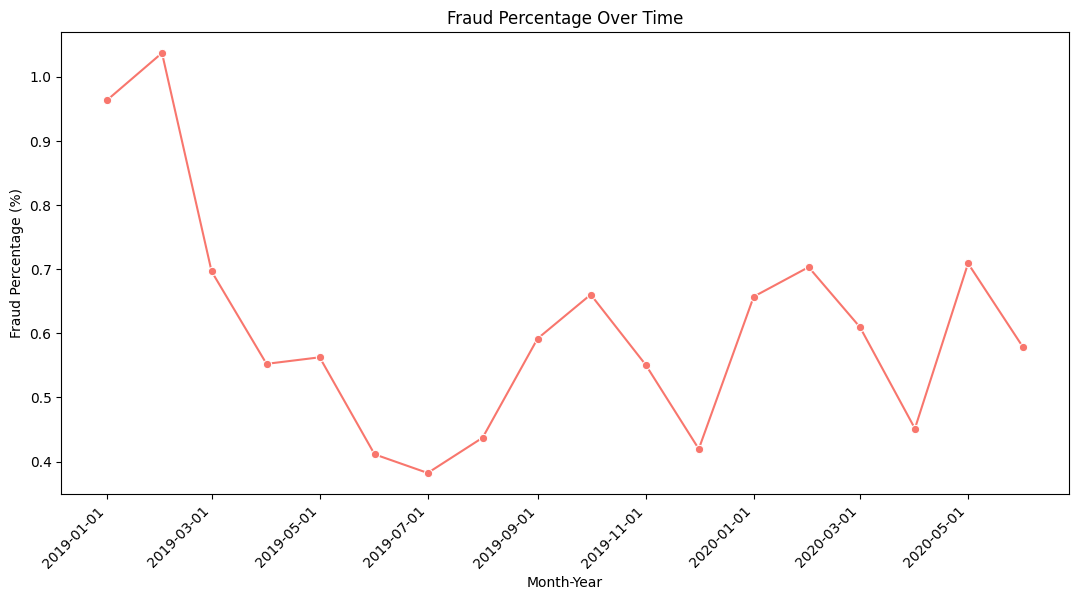

In [20]:
# Converter 'month_year' para um formato de data
df['month_year'] = pd.to_datetime(df['month_year'], format='%m-%Y')

# Calcular a porcentagem de fraudes em relação a todas as transações por mês-ano
fraud_percentage_per_month = df.groupby(['month_year', 'is_fraud']).size().unstack(fill_value=0).apply(lambda x: x[1] / (x[0] + x[1]) * 100, axis=1)



# Plotar o gráfico de linha
plt.figure(figsize=(13, 6))
sns.lineplot(x=fraud_percentage_per_month.index, y=fraud_percentage_per_month.values, marker='o', color='#F8766D')
plt.xlabel('Month-Year')
plt.ylabel('Fraud Percentage (%)')
plt.title('Fraud Percentage Over Time')
plt.xticks(rotation=45, ha='right')
plt.xticks(fraud_percentage_per_month.index[::2], rotation=45, ha='right')
plt.show()


### Hour


When analyzing the time at which transactions occurred, it becomes evident that **fraudulent transactions are predominantly made from 22:00 to 03:00.**

*This is clear from:*

1. The difference between the concentration graph of transactions per hour for legitimate and fraudulent transactions.
2. The two distribution graphs for both types in relation to the hour.

**Business Actions**
1. Implement more aggressive predictive mechanisms during this time period
2. Upsize the support team for victims during these hours, to facilitate quicker response and loss mitigation.

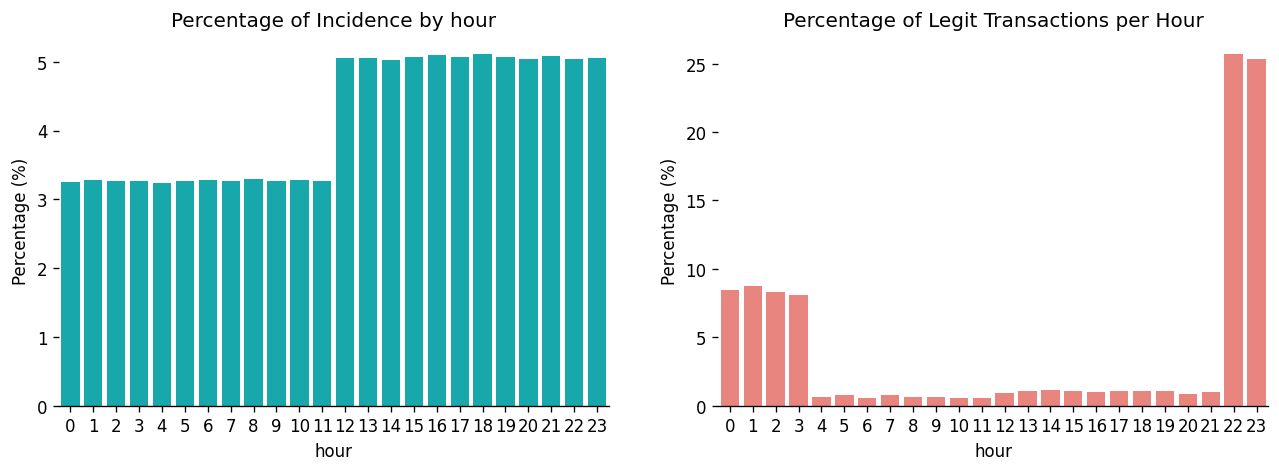

In [21]:
plt.figure(figsize=(13, 4))

# Plot for is_fraud = 0
plt.subplot(1, 2, 1)
percentage_per_day_fraud_0 = df[df['is_fraud'] == 0]['hour'].value_counts(normalize=True) * 100
sns.barplot(x=percentage_per_day_fraud_0.index, y=percentage_per_day_fraud_0.values, color='#00BFC4')
plt.xlabel('hour')
plt.ylabel('Percentage (%)')
plt.title('Percentage of Incidence by hour')

# Plot for is_fraud = 1
plt.subplot(1, 2, 2)
percentage_per_day_fraud_1 = df[df['is_fraud'] == 1]['hour'].value_counts(normalize=True) * 100
sns.barplot(x=percentage_per_day_fraud_1.index, y=percentage_per_day_fraud_1.values, color='#F8766D')
plt.xlabel('hour')
plt.ylabel('Percentage (%)')
plt.title('Percentage of Legit Transactions per Hour')

plt.gcf().set_dpi(120)
sns.despine(left=True)
plt.show()


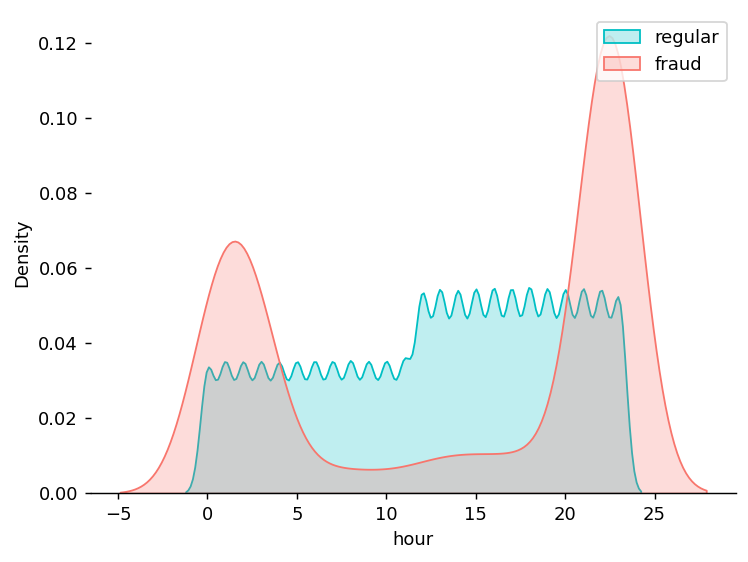

In [22]:
sns.kdeplot(data=df[df['is_fraud'] == 0], x='hour', fill=True,common_norm=False, color = '#00BFC4', label = 'regular')
sns.kdeplot(data=df[df['is_fraud'] == 1], x='hour', fill=True, common_norm=False, color ='#F8766D', label = 'fraud')


plt.gcf().set_dpi(130)
sns.despine( left=True)
plt.legend()
plt.show()


***Notice the spike at 22 hours***

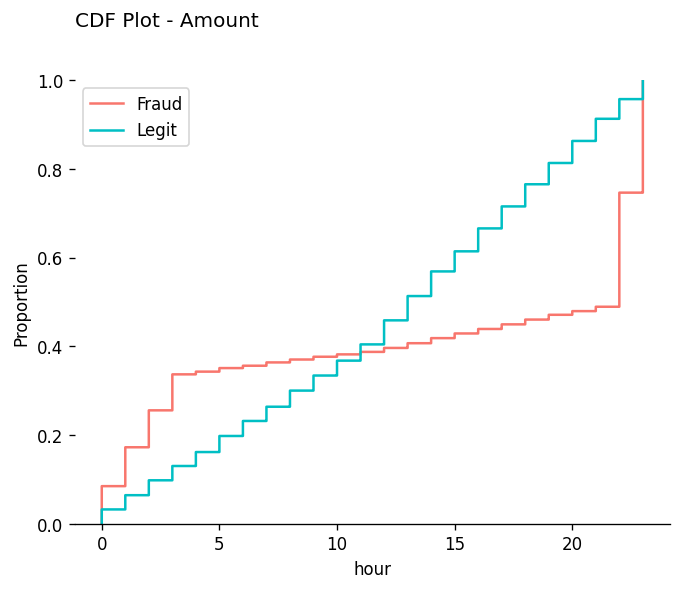

In [23]:
sns.ecdfplot(dist_fraud_df, stat='proportion',x = 'hour', color = '#F8766D', label = 'Fraud')
sns.ecdfplot(dist_legit_df, stat='proportion',x = 'hour', color = '#00BFC4', label = 'Legit' )

plt.title("CDF Plot - Amount \n \n", loc = 'left')
plt.gcf().set_dpi(120)
sns.despine( left=True)
plt.legend()
plt.show()

### Day of Week
There is not much diference when it comes to day of the week. Fraudsters do not tend to target a particular day.

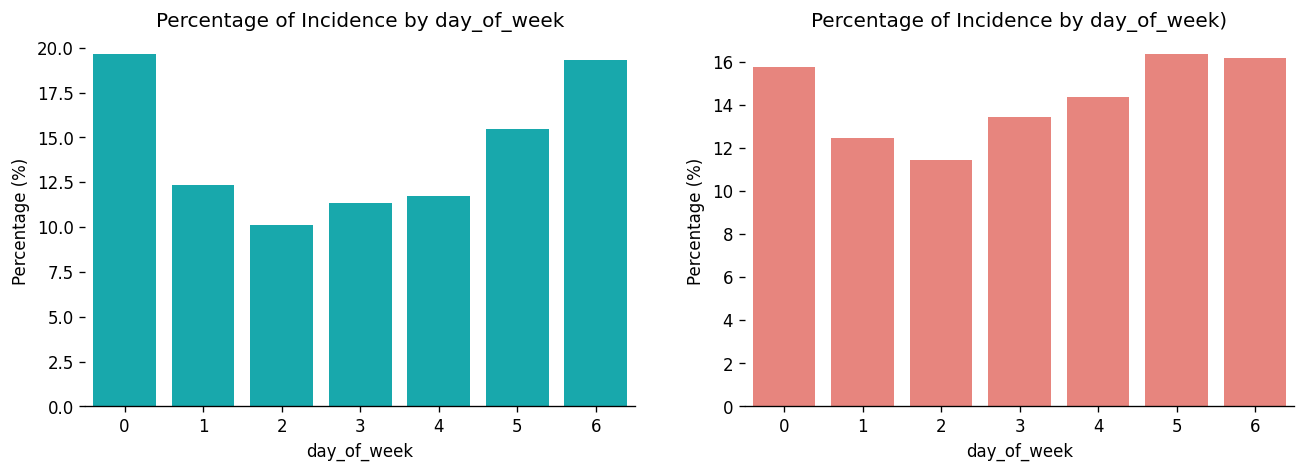

In [24]:
plt.figure(figsize=(13, 4))

# Plot for is_fraud = 0
plt.subplot(1, 2, 1)
percentage_per_day_fraud_0 = df[df['is_fraud'] == 0]['day_of_week'].value_counts(normalize=True) * 100
sns.barplot(x=percentage_per_day_fraud_0.index, y=percentage_per_day_fraud_0.values, color='#00BFC4')
plt.xlabel('day_of_week')
plt.ylabel('Percentage (%)')
plt.title('Percentage of Incidence by day_of_week')

# Plot for is_fraud = 1
plt.subplot(1, 2, 2)
percentage_per_day_fraud_1 = df[df['is_fraud'] == 1]['day_of_week'].value_counts(normalize=True) * 100
sns.barplot(x=percentage_per_day_fraud_1.index, y=percentage_per_day_fraud_1.values, color='#F8766D')
plt.xlabel('day_of_week')
plt.ylabel('Percentage (%)')
plt.title('Percentage of Incidence by day_of_week)')

plt.gcf().set_dpi(120)
sns.despine(left=True)
plt.show()

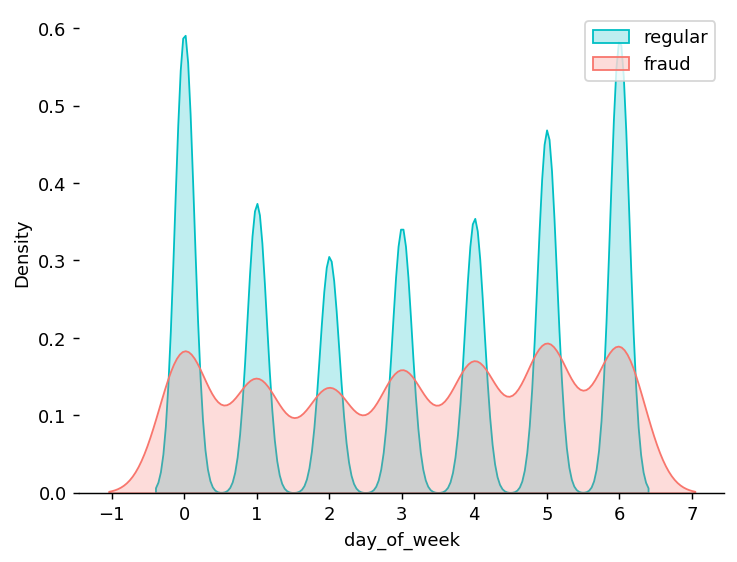

In [25]:
sns.kdeplot(data=df[df['is_fraud'] == 0], x='day_of_week', fill=True,common_norm=False, color = '#00BFC4', label = 'regular')
sns.kdeplot(data=df[df['is_fraud'] == 1], x='day_of_week', fill=True, common_norm=False, color ='#F8766D', label = 'fraud')


plt.gcf().set_dpi(130)
sns.despine( left=True)
plt.legend()
plt.show()

### Day

In the case of the day of the month, there is a slight difference between the two, especially between days 10-15 and 20-25. This difference in behavior becomes more evident in the distribution graph.

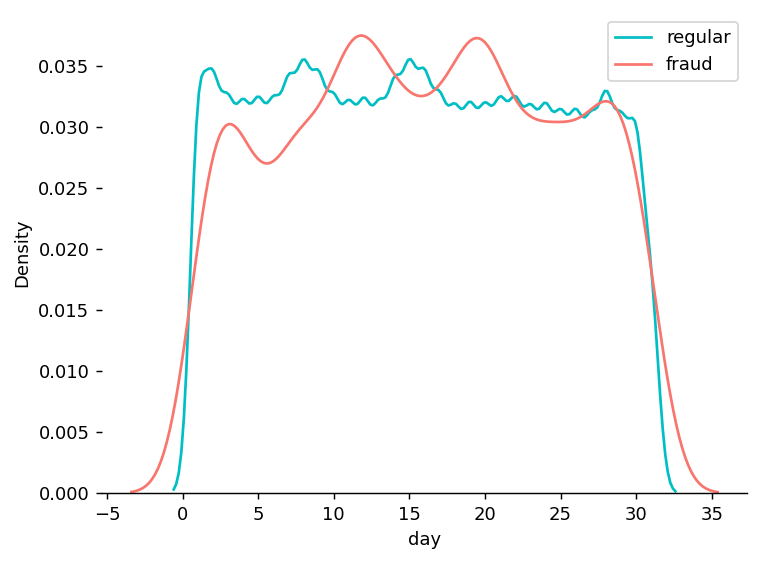

In [26]:
sns.kdeplot(data=df[df['is_fraud'] == 0], x='day', fill=False,common_norm=False, color = '#00BFC4', label = 'regular')
sns.kdeplot(data=df[df['is_fraud'] == 1], x='day', fill=False, common_norm=False, color ='#F8766D', label = 'fraud')


plt.gcf().set_dpi(130)
sns.despine( left=True)
plt.legend()
plt.show()

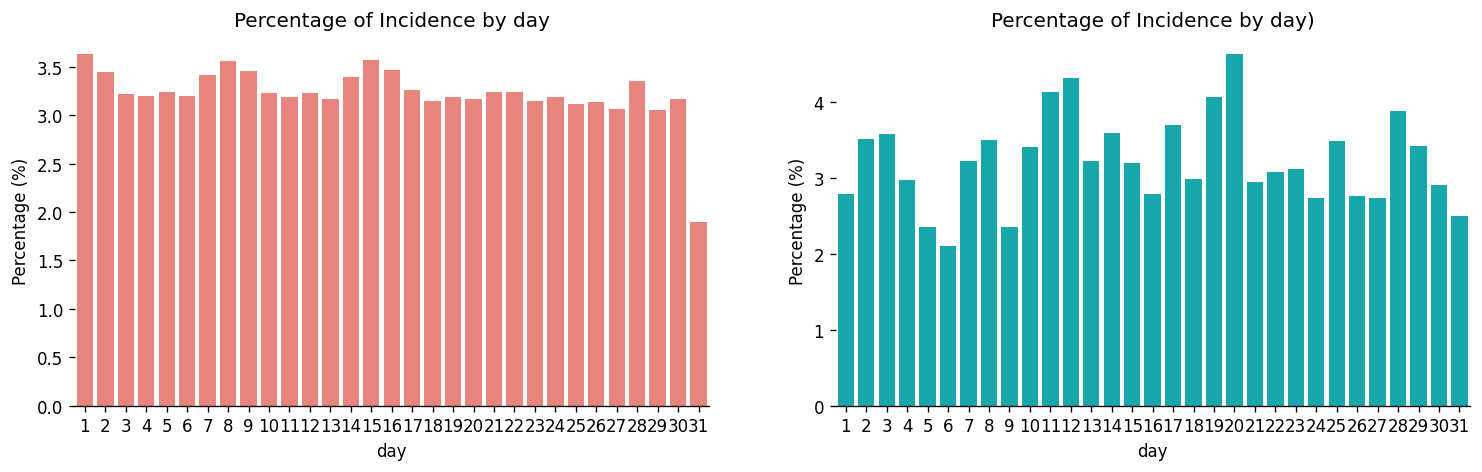

In [27]:
plt.figure(figsize=(15, 4))

# Plot for is_fraud = 0
plt.subplot(1, 2, 1)
percentage_per_day_fraud_0 = df[df['is_fraud'] == 0]['day'].value_counts(normalize=True) * 100
sns.barplot(x=percentage_per_day_fraud_0.index, y=percentage_per_day_fraud_0.values, color='#F8766D')
plt.xlabel('day')
plt.ylabel('Percentage (%)')
plt.title('Percentage of Incidence by day')

# Plot for is_fraud = 1
plt.subplot(1, 2, 2)
percentage_per_day_fraud_1 = df[df['is_fraud'] == 1]['day'].value_counts(normalize=True) * 100
sns.barplot(x=percentage_per_day_fraud_1.index, y=percentage_per_day_fraud_1.values, color='#00BFC4')
plt.xlabel('day')
plt.ylabel('Percentage (%)')
plt.title('Percentage of Incidence by day)')

plt.gcf().set_dpi(120)
sns.despine(left=True)
plt.show()

### Time Since Last Transaction

This variable represents intra-transactional time.

> The descriptive statistics reveal a **notably shorter  intra-transactional for fraudulent transactions** with a smaller standard deviation, ***a characteristic behavior of fraudsters attempting to maximize their gains per scam in a short timeframe.***

> On the minute scale, these differences become even more pronounced. ***For this reason, we will use the minute scale in the machine learning model***. We will not use both to avoid multicollinearity.



*It's important to note that both fraudulent and legitimate transactions have short intervals, but legitimate transactions exhibit a more dramatically fat-tailed distribution. In other words, they tend to have more extreme values more frequently, distinguishing the two groups.*



#### Hours Since Last Transaction

In [28]:
fraud_amt_describe = fraud_df['hours_since_previous_transaction'].describe(percentiles=[.25, .5, .75, .95]).round(2)
regular_amt_describe = regular_df['hours_since_previous_transaction'].describe(percentiles=[.25, .5, .75, .95]).round(2)

fraud_amt_describe.loc['95%'] = fraud_df['hours_since_previous_transaction'].quantile(0.95).round(2)
regular_amt_describe.loc['95%'] = regular_df['hours_since_previous_transaction'].quantile(0.95).round(2)

combined_df = pd.concat([ regular_amt_describe,fraud_amt_describe,], axis=1)
combined_df.columns = ['Regular', 'Fraud']

print(combined_df)

          Regular    Fraud
count  1288261.00  6744.00
mean         9.07     4.58
std         13.28     6.69
min          0.00     0.00
25%          1.68     0.36
50%          4.62     1.08
75%         11.20     5.85
95%         31.93    20.22
max        372.63    43.00


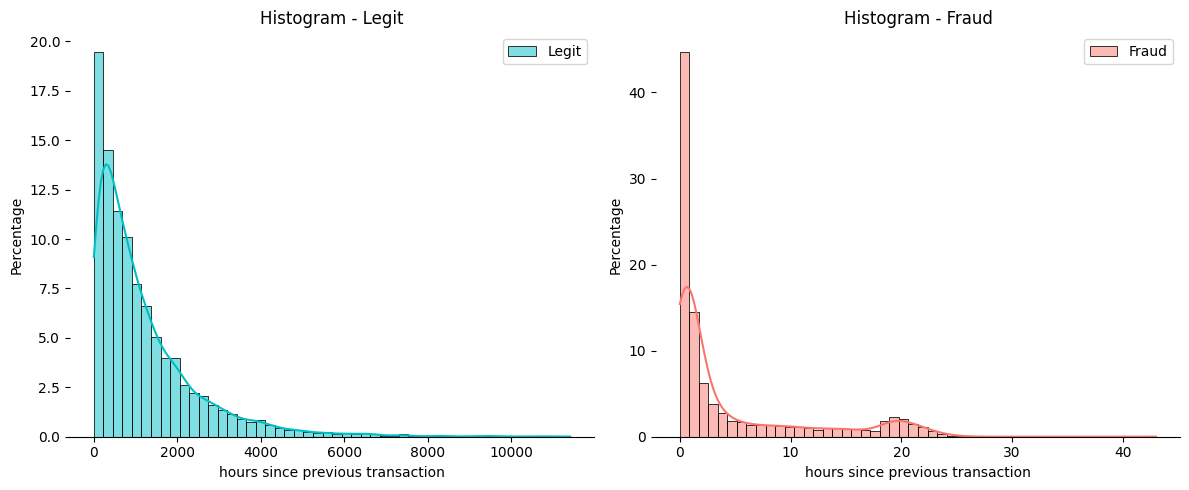

In [29]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.histplot(data=dist_legit_df, x="hours_since_previous_transaction", color="#00BFC4", label="Legit", kde=True, bins=50, stat='percent')
plt.title("Histogram - Legit")
plt.xlabel("hours since previous transaction")
plt.ylabel("Percentage")
sns.despine(left=True)
plt.legend()

plt.subplot(1, 2, 2)
sns.histplot(data=dist_fraud_df, x="hours_since_previous_transaction", color="#F8766D", label="Fraud", kde=True, bins=50, stat='percent')
plt.title("Histogram - Fraud")
plt.xlabel("hours since previous transaction")
plt.ylabel("Percentage")
sns.despine(left=True)
plt.legend()

plt.tight_layout()
plt.show()


### Minutes Since Last Transaction

In [30]:
fraud_amt_describe = fraud_df['minutes_since_previous_transaction'].describe(percentiles=[.25, .5, .75, .95]).round(2)
regular_amt_describe = regular_df['minutes_since_previous_transaction'].describe(percentiles=[.25, .5, .75, .95]).round(2)

fraud_amt_describe.loc['95%'] = fraud_df['minutes_since_previous_transaction'].quantile(0.95).round(2)
regular_amt_describe.loc['95%'] = regular_df['minutes_since_previous_transaction'].quantile(0.95).round(2)

combined_df = pd.concat([ regular_amt_describe,fraud_amt_describe,], axis=1)
combined_df.columns = ['Regular', 'Fraud']

# Exiba os resultados
print(combined_df)

          Regular    Fraud
count  1288261.00  6744.00
mean       544.39   274.53
std        796.93   401.62
min          0.00     0.02
25%        101.08    21.48
50%        277.20    64.88
75%        671.78   351.07
95%       1915.62  1213.28
max      22357.85  2579.92


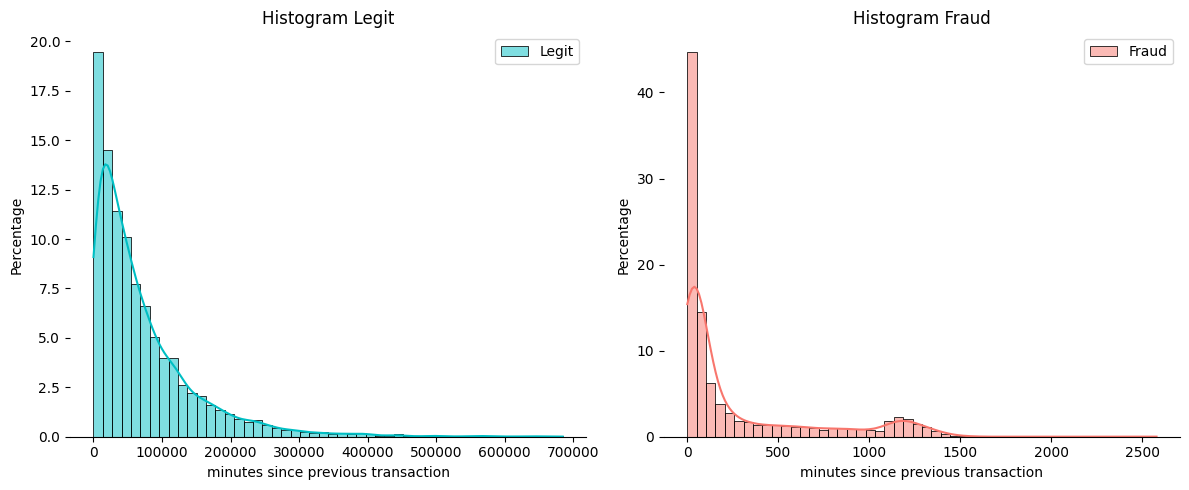

In [31]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.histplot(data=dist_legit_df, x="minutes_since_previous_transaction", color="#00BFC4", label="Legit", kde=True, bins=50, stat='percent')
plt.title("Histogram Legit")
plt.xlabel("minutes since previous transaction")
plt.ylabel("Percentage")
sns.despine(left=True)
plt.legend()

plt.subplot(1, 2, 2)
sns.histplot(data=dist_fraud_df, x="minutes_since_previous_transaction", color="#F8766D", label="Fraud", kde=True, bins=50, stat='percent')
plt.title("Histogram Fraud")
plt.xlabel("minutes since previous transaction")
plt.ylabel("Percentage")
sns.despine(left=True)
plt.legend()

plt.tight_layout()
plt.show()


#### Age

In [32]:
fraud_amt_describe = fraud_df['age'].describe(percentiles=[.25, .5, .75, .95]).round(2)
regular_amt_describe = regular_df['age'].describe(percentiles=[.25, .5, .75, .95]).round(2)

fraud_amt_describe.loc['95%'] = fraud_df['age'].quantile(0.95).round(2)
regular_amt_describe.loc['95%'] = regular_df['age'].quantile(0.95).round(2)

combined_df = pd.concat([ regular_amt_describe,fraud_amt_describe,], axis=1)
combined_df.columns = ['Regular', 'Fraud']

# Exiba os resultados
print(combined_df)

          Regular    Fraud
count  1289169.00  7506.00
mean        46.01    48.87
std         17.37    18.86
min         14.00    14.00
25%         33.00    33.00
50%         44.00    48.00
75%         57.00    61.00
95%         80.00    84.00
max         96.00    94.00


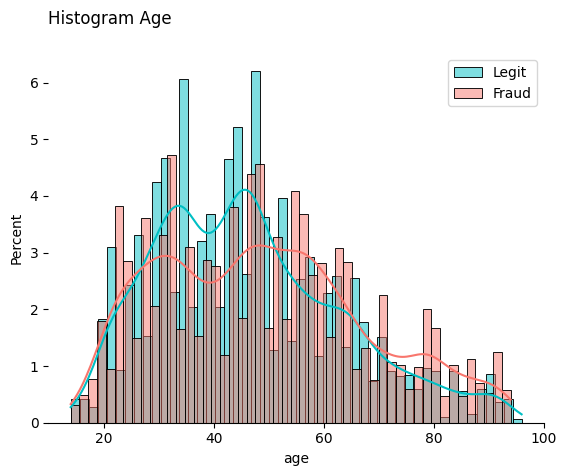

In [33]:
# plt.figure(figsize=(12, 8))
sns.histplot(data=dist_legit_df, x="age", color="#00BFC4", label="Legit", kde=True, bins=50, stat='percent')
sns.histplot(data=dist_fraud_df, x="age", color="#F8766D", label="Fraud", kde=True, bins=50, stat='percent')

plt.title("Histogram Age \n", loc = 'left')
# plt.gcf().set_dpi(130)
sns.despine( left=True)
plt.legend()
plt.show()

### Account Number
> Initially, this variable did not reveal much potential to identify fraud. However, it highlighted one of the most important points: **almost 80% of this customer base has already been a victim of credit card fraud.**

> This information is highly concerning and needs to be addressed, especially since recent research indicates that ***customers expect financial institutions to be responsible for this issue and to have excellent defense mechanisms.***

> Knowing that this happens to the vast majority of customers is very worrisome, as the ***churn rate due to these events is certainly high, leading to a very poor customer experience.***

> **With this scenario, the company faces serious risks of not surviving in this extremely competitive market.**

*ps: One point to consider is that this may be a sampling bias, and further investigation is needed in this regard.*

In [34]:
# Calculate the percentage of cc_num with fraud relative to the total unique cc_num
total_cc_num = len(df['cc_num'].unique())
cc_num_with_fraud = len(df[df['is_fraud'] == 1]['cc_num'].unique())

percentage_cc_num_with_fraud = (cc_num_with_fraud / total_cc_num) * 100

print(f'The percentage of cc_num with fraud is: {percentage_cc_num_with_fraud:.2f}%')



The percentage of cc_num with fraud is: 77.52%


### Merchant

> Variable without significant considerations. Note the presence of the `fraud_` prefix, but they are all the same. I investigated the type of company to see if any type has a higher incidence, but without success.

> The only noteworthy point is that 97% of the merchants have been involved in some fraud, possibly a sample bias but should be investigated more thoroughly.

In [35]:
prefixo = 'fraud_'
merchfrandpercent = (df['merchant'].str.startswith(prefixo).mean()) * 100

merchfrandpercent

100.0

In [36]:
# Calculate the percentage of merchant with fraud relative to the total unique merchants
total_merchants = len(df['merchant'].unique())
merchants_with_fraud = len(df[df['is_fraud'] == 1]['merchant'].unique())

percentage_merchants_with_fraud = (merchants_with_fraud / total_merchants) * 100

print(f'The percentage of merchants with fraud is: {percentage_merchants_with_fraud:.2f}%')


The percentage of merchants with fraud is: 97.98%


In [37]:
df['merchant'].value_counts().head(20)

fraud_Kilback LLC                       4403
fraud_Cormier LLC                       3649
fraud_Schumm PLC                        3634
fraud_Kuhn LLC                          3510
fraud_Boyer PLC                         3493
fraud_Dickinson Ltd                     3434
fraud_Cummerata-Jones                   2736
fraud_Kutch LLC                         2734
fraud_Olson, Becker and Koch            2723
fraud_Stroman, Hudson and Erdman        2721
fraud_Rodriguez Group                   2716
fraud_Erdman-Kertzmann                  2705
fraud_Jenkins, Hauck and Friesen        2705
fraud_Kling Inc                         2687
fraud_Connelly, Reichert and Fritsch    2684
fraud_Friesen-Stamm                     2680
fraud_Prohaska-Murray                   2679
fraud_Huels-Hahn                        2678
fraud_Berge LLC                         2677
fraud_Bartoletti-Wunsch                 2676
Name: merchant, dtype: int64

In [38]:
fraud_df['merchant'].value_counts().head(20)

fraud_Rau and Sons                     49
fraud_Cormier LLC                      48
fraud_Kozey-Boehm                      48
fraud_Doyle Ltd                        47
fraud_Vandervort-Funk                  47
fraud_Kilback LLC                      47
fraud_Padberg-Welch                    44
fraud_Kuhn LLC                         44
fraud_Terry-Huel                       43
fraud_Koepp-Witting                    42
fraud_Goyette Inc                      42
fraud_Jast Ltd                         42
fraud_Kiehn-Emmerich                   41
fraud_Kerluke-Abshire                  41
fraud_Schmeler, Bashirian and Price    41
fraud_McDermott-Weimann                41
fraud_Hudson-Ratke                     40
fraud_Gleason-Macejkovic               40
fraud_Moen, Reinger and Murphy         40
fraud_Boyer PLC                        40
Name: merchant, dtype: int64

In [39]:
patterns = ['LLC','Inc','PLC']
fraud_merchants = df[df['is_fraud'] == 1]['merchant']
non_fraud_merchants = df[df['is_fraud'] == 0]['merchant']

fraud_percentage_matching_merchants = (fraud_merchants.str.contains('|'.join(patterns)).sum() / len(fraud_merchants)) * 100

non_fraud_percentage_matching_merchants = (non_fraud_merchants.str.contains('|'.join(patterns)).sum() / len(non_fraud_merchants)) * 100

print(f'The percentage of merchants with the specified patterns for fraud transactions is: {fraud_percentage_matching_merchants:.2f}%')
print(f'The percentage of merchants with the specified patterns for non-fraud transactions is: {non_fraud_percentage_matching_merchants:.2f}%')



The percentage of merchants with the specified patterns for fraud transactions is: 21.56%
The percentage of merchants with the specified patterns for non-fraud transactions is: 19.75%


### Category


> It's interesting to note the significant concentration of `grocery_pos` and `shopping_net` as categories in fraudulent transactions. Together, they **represent almost 50% of the database**, whereas in legitimate transactions, they represent only 16%.

**Business Actions:**

1. Implement specific fraud mechanisms for these groups.
2. Investigate if there is any specific scheme within these industries.



In [40]:
print(f"Total of {df.category.nunique()} categories")

Total of 14 categories


In [41]:
print("Most relevant categories in legitimate transactions.\n")
(regular_df.category.value_counts()/regular_df.shape[0]).head(5)

Most relevant categories in legitimate transactions.



gas_transport    0.101648
home             0.095346
grocery_pos      0.094553
shopping_pos     0.089848
kids_pets        0.087495
Name: category, dtype: float64

In [42]:
print("Most relevant categories in fraudulent transactions.\n")
(fraud_df.category.value_counts()/fraud_df.shape[0]).head(5)

Most relevant categories in fraudulent transactions.



grocery_pos      0.232214
shopping_net     0.228217
misc_net         0.121902
shopping_pos     0.112310
gas_transport    0.082334
Name: category, dtype: float64

In [43]:
# Calculate the percentage of 'grocery_pos' and 'shopping_net' categories for fraud transactions
fraud_category_percentage = (fraud_df['category'].value_counts() / fraud_df.shape[0])

# Calculate the percentage of 'grocery_pos' and 'shopping_net' categories for regular transactions
regular_category_percentage = (regular_df['category'].value_counts() / regular_df.shape[0])

# Select the values for 'grocery_pos' and 'shopping_net'
selected_categories_fraud = fraud_category_percentage.loc[['grocery_pos', 'shopping_net']]
selected_categories_regular = regular_category_percentage.loc[['grocery_pos', 'shopping_net']]

# Calculate the sum of the selected values
sum_selected_categories_fraud = selected_categories_fraud.sum()
sum_selected_categories_regular = selected_categories_regular.sum()

# Print the results
print("Sum of Percentage for 'grocery_pos' and 'shopping_net' in Fraud Transactions:")
print(sum_selected_categories_fraud)

print("\nSum of Percentage for 'grocery_pos' and 'shopping_net' in Regular Transactions:")
print(sum_selected_categories_regular)



Sum of Percentage for 'grocery_pos' and 'shopping_net' in Fraud Transactions:
0.460431654676259

Sum of Percentage for 'grocery_pos' and 'shopping_net' in Regular Transactions:
0.1688878649734829


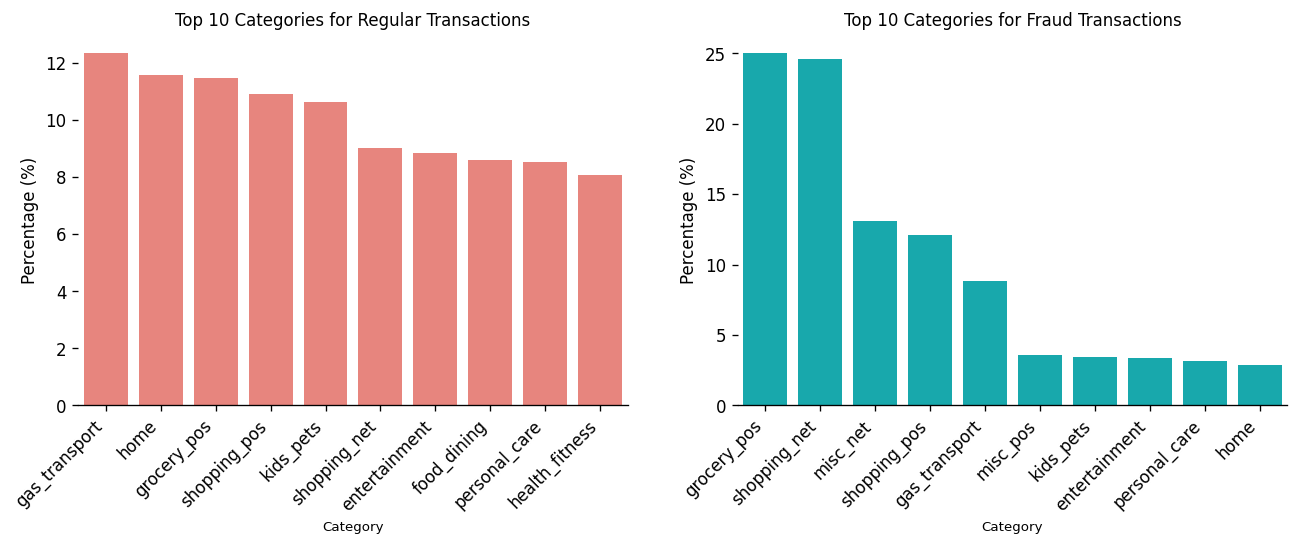

In [44]:

top_regular_categories = regular_df['category'].value_counts().head(10).index
top_fraud_categories = fraud_df['category'].value_counts().head(10).index

filtered_regular_data = regular_df[regular_df['category'].isin(top_regular_categories)]
filtered_fraud_data = fraud_df[fraud_df['category'].isin(top_fraud_categories)]

plt.figure(figsize=(13, 4))

plt.subplot(1, 2, 1)
percentage_per_category_regular = filtered_regular_data['category'].value_counts(normalize=True) * 100
sns.barplot(x=percentage_per_category_regular.index, y=percentage_per_category_regular.values, color='#F8766D')
plt.xlabel('Category', fontsize=8)
plt.ylabel('Percentage (%)')
plt.title('Top 10 Categories for Regular Transactions', fontsize=10)
plt.xticks(rotation=45, ha='right')

plt.subplot(1, 2, 2)
percentage_per_category_fraud = filtered_fraud_data['category'].value_counts(normalize=True) * 100
sns.barplot(x=percentage_per_category_fraud.index, y=percentage_per_category_fraud.values, color='#00BFC4')
plt.xlabel('Category', fontsize=8)
plt.ylabel('Percentage (%)')
plt.title('Top 10 Categories for Fraud Transactions', fontsize=10)
plt.xticks(rotation=45, ha='right')

plt.gcf().set_dpi(120)
sns.despine(left=True)
plt.show()


### Amount

> Amount proved to be a complex variable to analyze due to its high skewness.

> However, it becomes very valuable when combined with other variables.

> Initially due to descriptive analytics, it became evident that frauds mostly occur at higher values (above 200).

In [45]:
df.amt.describe().round(2)

count    1296675.00
mean          70.35
std          160.32
min            1.00
25%            9.65
50%           47.52
75%           83.14
max        28948.90
Name: amt, dtype: float64

In [46]:
n99 = df.amt.quantile(.99)
n95 = df.amt.quantile(.95)

In [47]:

fraud_amt_describe = fraud_df['amt'].describe(percentiles=[.95]).round(2)
regular_amt_describe = regular_df['amt'].describe(percentiles=[.95]).round(2)

fraud_amt_describe.loc['95%'] = fraud_df['amt'].quantile(0.95).round(2)
regular_amt_describe.loc['95%'] = regular_df['amt'].quantile(0.95).round(2)

combined_df = pd.concat([ regular_amt_describe,fraud_amt_describe,], axis=1)
combined_df.columns = ['Regular', 'Fraud']

print(combined_df)


          Regular    Fraud
count  1289169.00  7506.00
mean        67.67   531.32
std        154.01   390.56
min          1.00     1.06
50%         47.28   396.50
95%        189.90  1083.99
max      28948.90  1376.04


In [48]:
# Filtrar transações que são maiores que 189.90 e são fraude
fraudulent_transactions = df[(df['amt'] > 189.90) & (df['is_fraud'] == 1)]

# Calcular a porcentagem em relação ao total de transações
percentage_fraudulent = (len(fraudulent_transactions) / len(df[df['amt'] > 189.90].sample(fraud_df.shape[0]))) * 100

print(f'A porcentagem de transações que são maiores que 189.90 e são fraude é: {percentage_fraudulent:.2f}%')


A porcentagem de transações que são maiores que 189.90 e são fraude é: 76.02%


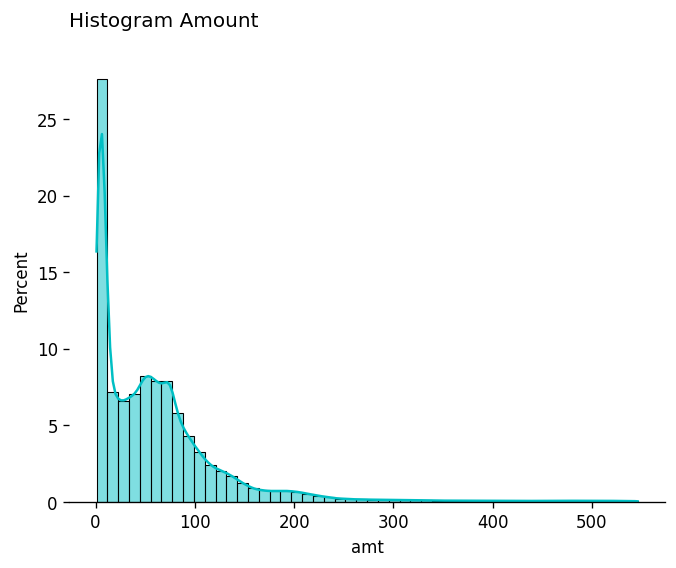

In [49]:
sns.histplot(data=df[df.amt <= n99], x="amt", kde=True, bins = 50, color="#00BFC4", stat='percent')

plt.title("Histogram Amount\n", loc = 'left')
plt.gcf().set_dpi(120)
sns.despine( left=True)
plt.show()

Skewness  amount: 42.27787379005119
kurtosis  amount: 4545.644979374184


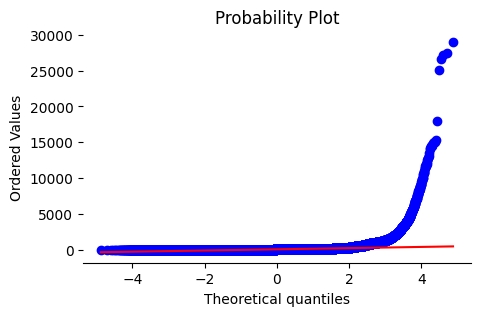

In [50]:
from scipy import stats
skewness = df["amt"].skew()
print(f"Skewness  amount: {skewness}")
kurtosis = df["amt"].kurtosis()
print(f"kurtosis  amount: {kurtosis}")
fig, (ax) = plt.subplots(figsize = (5,3))
res = stats.probplot(df["amt"],dist='norm', plot=ax)
#plt.title("Histograma Amount\n", loc = 'left')
plt.gcf().set_dpi(100)
sns.despine( left=True)
plt.show()

**Note the increase in fraud after 200 in the two distribution graphs below.**

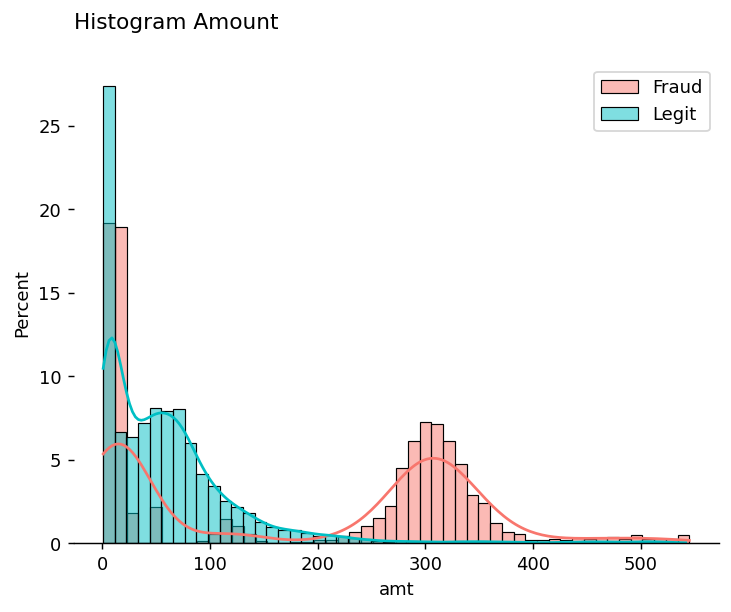

In [51]:
# plt.figure(figsize=(12, 8))
sns.histplot(data=dist_fraud_df[(dist_fraud_df.amt <= n99) & (dist_fraud_df.is_fraud == 1)], x="amt", color="#F8766D", label="Fraud", kde=True, bins=50, stat='percent')

sns.histplot(data=dist_legit_df[(dist_legit_df.amt <= n99) & (dist_legit_df.is_fraud == 0)], x="amt", color="#00BFC4", label="Legit", kde=True, bins=50, stat='percent')

plt.title("Histogram Amount\n", loc = 'left')
plt.gcf().set_dpi(130)
sns.despine( left=True)
plt.legend()
plt.show()

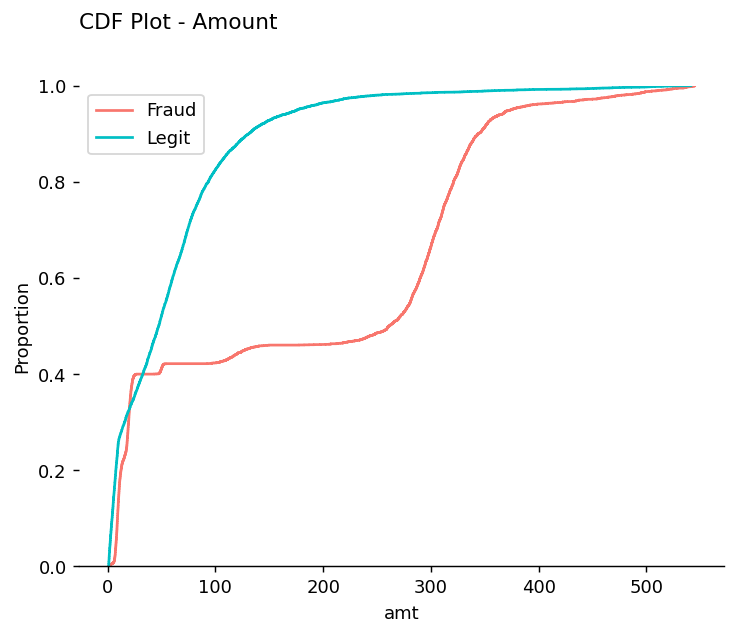

In [52]:
sns.ecdfplot(dist_fraud_df[(dist_fraud_df.amt <= n99) & (dist_fraud_df.is_fraud == 1)]['amt'], stat='proportion', color = '#F8766D', label = 'Fraud')
sns.ecdfplot(dist_legit_df[(dist_legit_df.amt <= n99) & (dist_legit_df.is_fraud == 0)]['amt'], stat='proportion', color = '#00BFC4', label = 'Legit' )

plt.title("CDF Plot - Amount \n \n", loc = 'left')
plt.gcf().set_dpi(130)
sns.despine( left=True)
plt.legend()
plt.show()

#### Amount & Category

> When analyzing the amount with category, it is noticeable that the distributions of **fraud values are much more predictable and with fewer outliers compared to legitimate transactions**. **In this sense, it is a good predictor and will greatly assist the model.**

> It's also important to mention that categories with higher fraud values are also those with a higher incidence of fraud, another point that favors the model.

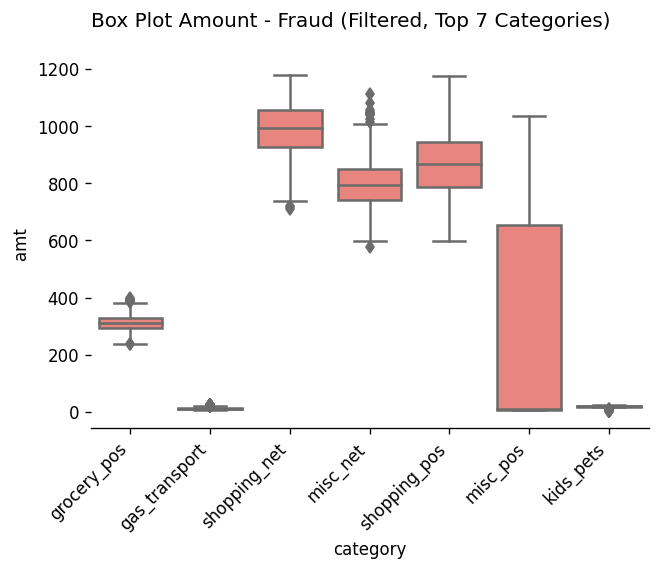

In [53]:
# Calcular o percentil 99 para 'amt' no fraud_df
amt_percentile_99 = fraud_df['amt'].quantile(0.99)

# Filtrar o fraud_df para incluir apenas transações com 'amt' < percentil 99
fraud_df_filtered = fraud_df[fraud_df['amt'] < amt_percentile_99]

# Obter as top 7 categorias por incidência
top_categories = fraud_df_filtered['category'].value_counts().head(7).index

# Filtrar novamente para incluir apenas as top 7 categorias
fraud_df_filtered_top7 = fraud_df_filtered[fraud_df_filtered['category'].isin(top_categories)]

# Criar o gráfico de caixa (box plot) para transações fraudulentas filtradas (top 7)
plt.figure(figsize=(6, 4))
sns.boxplot(x='category', y='amt', data=fraud_df_filtered_top7, palette=["#F8766D"])
plt.title("Box Plot Amount - Fraud (Filtered, Top 7 Categories)\n", loc='left')
plt.xticks(rotation=45, ha='right')  # Rotacionar rótulos do eixo x
plt.gcf().set_dpi(120)
sns.despine(left=True)
plt.show()

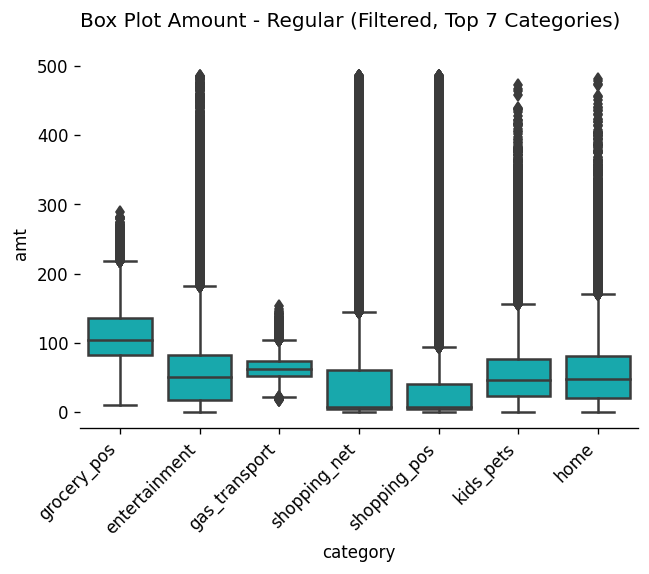

In [54]:
# Calcular o percentil 99 para 'amt' no fraud_df
amt_percentile_99 = regular_df['amt'].quantile(0.99)

# Filtrar o fraud_df para incluir apenas transações com 'amt' < percentil 99
regular_df_filtered = regular_df[regular_df['amt'] < amt_percentile_99]

# Obter as top 7 categorias por incidência
top_categories = regular_df_filtered['category'].value_counts().head(7).index

# Filtrar novamente para incluir apenas as top 7 categorias
regular_df_filtered_top7 = regular_df_filtered[regular_df_filtered['category'].isin(top_categories)]

# Criar o gráfico de caixa (box plot) para transações fraudulentas filtradas (top 7)
plt.figure(figsize=(6, 4))
sns.boxplot(x='category', y='amt', data=regular_df_filtered_top7, palette=["#00BFC4"])
plt.title("Box Plot Amount - Regular (Filtered, Top 7 Categories)\n", loc='left')
plt.xticks(rotation=45, ha='right')  # Rotacionar rótulos do eixo x
plt.gcf().set_dpi(120)
sns.despine(left=True)
plt.show()

#### Amount & City Pop

> The calculation of the ratio of amount to city population, as revealed by descriptive statistics and distribution analysis, indicates that this indicator is higher in cases of fraud and is quite sensitive. Therefore, it may significantly assist the model.



In [55]:
fraud_amt_describe = fraud_df['amount_to_city_pop_ratio'].describe(percentiles=[.25, .5, .75, .95]).round(2)
regular_amt_describe = regular_df['amount_to_city_pop_ratio'].describe(percentiles=[.25, .5, .75, .95]).round(2)

fraud_amt_describe.loc['95%'] = fraud_df['amount_to_city_pop_ratio'].quantile(0.95).round(2)
regular_amt_describe.loc['95%'] = regular_df['amount_to_city_pop_ratio'].quantile(0.95).round(2)

combined_df = pd.concat([ regular_amt_describe,fraud_amt_describe,], axis=1)
combined_df.columns = ['Regular', 'Fraud']

print(combined_df)

          Regular    Fraud
count  1289169.00  7506.00
mean         0.10     0.82
std          0.71     2.31
min          0.00     0.00
25%          0.00     0.01
50%          0.01     0.09
75%          0.06     0.54
95%          0.44     4.06
max        396.56    46.22


In [56]:
p_99_ratio_regular = dist_legit_df['amount_to_city_pop_ratio'].quantile(.99)
p_99_ratio_fraud = dist_fraud_df['amount_to_city_pop_ratio'].quantile(.99)

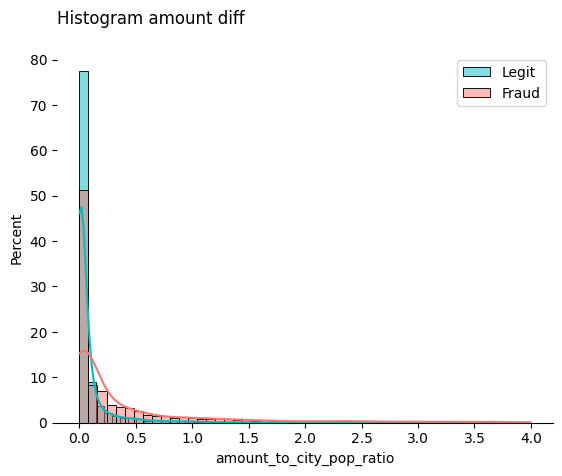

In [57]:
# plt.figure(figsize=(12, 8))
sns.histplot(data= dist_legit_df[dist_legit_df.amount_to_city_pop_ratio <=4], x="amount_to_city_pop_ratio", color="#00BFC4", label="Legit", kde=True, bins=50, stat='percent')
sns.histplot(data= dist_fraud_df[dist_fraud_df.amount_to_city_pop_ratio <=4], x="amount_to_city_pop_ratio", color="#F8766D", label="Fraud", kde=True, bins=50, stat='percent')

plt.title("Histogram amount diff \n", loc = 'left')
sns.despine( left=True)
plt.legend()
plt.show()

#### Amount Deviation

These are a series of variables measuring the deviation of the amount concerning another measure. I will comment on all of them now because both the analysis and the explanation are very similar, and it would be repetitive.

- `amt_diff`: This is the difference between the amount of the current transaction and the previous transaction of the same customer.
- `amount_deviation_from_mean`: It's the deviation from the customer's transactional mean.
- `amount_deviation_from_median`: It's the deviation from the customer's transactional median.
- `amount_deviation_from_hour_mean`: It's the deviation from the mean of transactions at the same hour.
- `amount_deviation_from_hour_median`: It's the deviation from the median of transactions at the same hour.

> The identified pattern is that legitimate transactions are typical, meaning they do not have a significant deviation from the norm.


> ***Fraudulent transactions exhibit the opposite behavior, with large positive and negative differences. Therefore, they assume a multimodal distribution, containing peaks at positive, negative, and near-zero values.*** These results were achieved by analyzing descriptive statistics and distribution analysis.

##### Amount Deviation previous transaction

In [58]:
fraud_amt_describe = fraud_df['amt_diff'].describe(percentiles=[.25, .5, .75, .95]).round(2)
regular_amt_describe = regular_df['amt_diff'].describe(percentiles=[.25, .5, .75, .95]).round(2)

fraud_amt_describe.loc['95%'] = fraud_df['amt_diff'].quantile(0.95).round(2)
regular_amt_describe.loc['95%'] = regular_df['amt_diff'].quantile(0.95).round(2)

combined_df = pd.concat([ regular_amt_describe,fraud_amt_describe,], axis=1)
combined_df.columns = ['Regular', 'Fraud']

# Exiba os resultados
print(combined_df)

          Regular    Fraud
count  1288261.00  6744.00
mean        -0.00    23.75
std        216.69   496.17
min     -28924.25 -1317.32
25%        -40.59  -278.24
50%          0.00     2.35
75%         40.63   310.02
95%        142.89   885.08
max      28910.08  1364.92


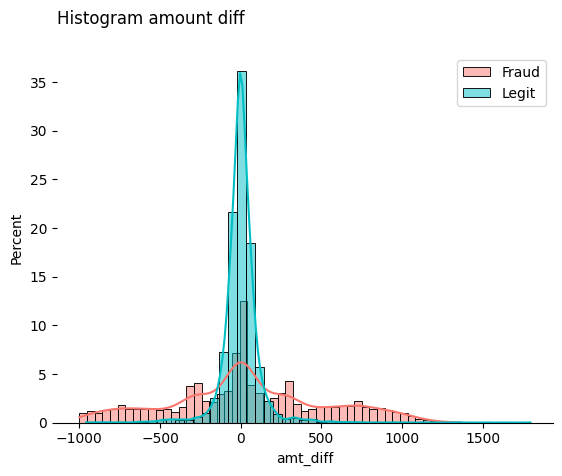

In [59]:
# plt.figure(figsize=(12, 8))
sns.histplot(data=dist_fraud_df[(dist_fraud_df["amt_diff"] > -1000) & (dist_fraud_df["amt_diff"] < 2000)], x="amt_diff", color="#F8766D", label="Fraud", kde=True, bins=50, stat='percent')
sns.histplot(data=dist_legit_df[(dist_legit_df["amt_diff"] > -1000) & (dist_legit_df["amt_diff"] < 2000)], x="amt_diff", color="#00BFC4", label="Legit", kde=True, bins=50, stat='percent')

plt.title("Histogram amount diff \n", loc = 'left')
sns.despine( left=True)

plt.legend()
plt.show()

##### Amount Deviation from The Mean

In [60]:
# Supondo que você tenha dois DataFrames chamados 'fraud_df' e 'regular_df'
fraud_amt_describe = fraud_df['amount_deviation_from_mean'].describe(percentiles=[.25, .5, .75, .95]).round(2)
regular_amt_describe = regular_df['amount_deviation_from_mean'].describe(percentiles=[.25, .5, .75, .95]).round(2)

# Adicione uma linha extra para indicar que é o percentil 95
fraud_amt_describe.loc['95%'] = fraud_df['amount_deviation_from_mean'].quantile(0.95).round(2)
regular_amt_describe.loc['95%'] = regular_df['amount_deviation_from_mean'].quantile(0.95).round(2)

# Combine os resultados em um DataFrame único
combined_df = pd.concat([ regular_amt_describe,fraud_amt_describe,], axis=1)
combined_df.columns = ['Regular', 'Fraud']

# Exiba os resultados
print(combined_df)

          Regular    Fraud
count  1289169.00  7506.00
mean         0.09    42.11
std        153.04   321.16
min       -715.21  -818.13
25%        -49.44  -193.75
50%        -21.62     0.00
75%         14.89   303.09
95%        113.79   546.77
max      28870.15   871.17


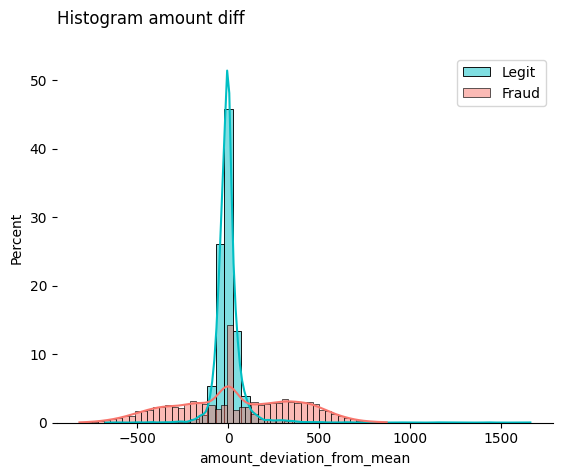

In [61]:
# plt.figure(figsize=(12, 8))
sns.histplot(data=dist_legit_df[(dist_legit_df["amount_deviation_from_mean"] > -1000) & (dist_legit_df["amount_deviation_from_mean"] < 2000)], x="amount_deviation_from_mean", color="#00BFC4", label="Legit", kde=True, bins=50, stat='percent')
sns.histplot(data=dist_fraud_df[(dist_fraud_df["amount_deviation_from_mean"] > -1000) & (dist_fraud_df["amount_deviation_from_mean"] < 2000)], x="amount_deviation_from_mean", color="#F8766D", label="Fraud", kde=True, bins=50, stat='percent')

plt.title("Histogram amount diff \n", loc = 'left')
# plt.gcf().set_dpi(130)
sns.despine( left=True)
plt.legend()
plt.show()

##### Amount Deviation from The Median

In [62]:
# Supondo que você tenha dois DataFrames chamados 'fraud_df' e 'regular_df'
fraud_amt_describe = fraud_df['amount_deviation_from_median'].describe(percentiles=[.25, .5, .75, .95]).round(2)
regular_amt_describe = regular_df['amount_deviation_from_median'].describe(percentiles=[.25, .5, .75, .95]).round(2)

# Adicione uma linha extra para indicar que é o percentil 95
fraud_amt_describe.loc['95%'] = fraud_df['amount_deviation_from_median'].quantile(0.95).round(2)
regular_amt_describe.loc['95%'] = regular_df['amount_deviation_from_median'].quantile(0.95).round(2)

# Combine os resultados em um DataFrame único
combined_df = pd.concat([ regular_amt_describe,fraud_amt_describe,], axis=1)
combined_df.columns = ['Regular', 'Fraud']

# Exiba os resultados
print(combined_df)

          Regular    Fraud
count  1289169.00  7506.00
mean        22.81    54.46
std        153.43   346.73
min       -715.21 -1040.12
25%        -27.93   -93.63
50%          0.00     0.00
75%         35.89   247.35
95%        141.40   679.92
max      28908.20  1229.71


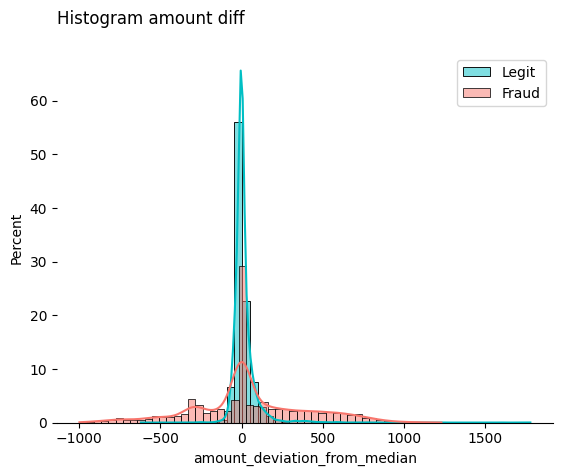

In [63]:
# plt.figure(figsize=(12, 8))
sns.histplot(data=dist_legit_df[(dist_legit_df["amount_deviation_from_median"] > -1000) & (dist_legit_df["amount_deviation_from_median"] < 2000)], x="amount_deviation_from_median", color="#00BFC4", label="Legit", kde=True, bins=50, stat='percent')
sns.histplot(data=dist_fraud_df[(dist_fraud_df["amount_deviation_from_median"] > -1000) & (dist_fraud_df["amount_deviation_from_median"] < 2000)], x="amount_deviation_from_median", color="#F8766D", label="Fraud", kde=True, bins=50, stat='percent')

plt.title("Histogram amount diff \n", loc = 'left')
# plt.gcf().set_dpi(130)
sns.despine( left=True)
plt.legend()
plt.show()

##### Deviation from Hour mean and median

##### deviation from hour mean

In [64]:
fraud_amt_describe = fraud_df['amount_deviation_from_hour_mean'].describe(percentiles=[.25, .5, .75, .95]).round(2)
regular_amt_describe = regular_df['amount_deviation_from_hour_mean'].describe(percentiles=[.25, .5, .75, .95]).round(2)

fraud_amt_describe.loc['95%'] = fraud_df['amount_deviation_from_hour_mean'].quantile(0.95).round(2)
regular_amt_describe.loc['95%'] = regular_df['amount_deviation_from_hour_mean'].quantile(0.95).round(2)

combined_df = pd.concat([ regular_amt_describe,fraud_amt_describe,], axis=1)
combined_df.columns = ['Regular', 'Fraud']

# Exiba os resultados
print(combined_df)

          Regular    Fraud
count  1289169.00  7506.00
mean        -0.00    -0.00
std        153.88   361.75
min        -75.41  -713.43
25%        -53.79  -333.35
50%        -21.54     0.31
75%         14.49   297.71
95%        120.06   516.84
max      28885.66   939.23


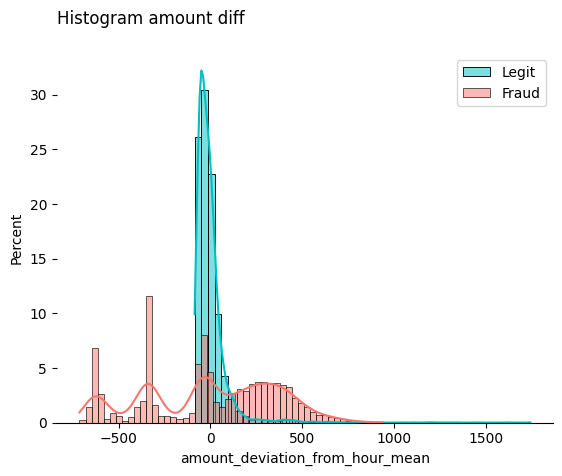

In [65]:
# plt.figure(figsize=(12, 8))
sns.histplot(data=dist_legit_df[(dist_legit_df["amount_deviation_from_hour_mean"] > -1000) & (dist_legit_df["amount_deviation_from_hour_mean"] < 2000)], x="amount_deviation_from_hour_mean", color="#00BFC4", label="Legit", kde=True, bins=50, stat='percent')
sns.histplot(data=dist_fraud_df[(dist_fraud_df["amount_deviation_from_hour_mean"] > -1000) & (dist_fraud_df["amount_deviation_from_hour_mean"] < 2000)], x="amount_deviation_from_hour_mean", color="#F8766D", label="Fraud", kde=True, bins=50, stat='percent')

plt.title("Histogram amount diff \n", loc = 'left')
# plt.gcf().set_dpi(130)
sns.despine( left=True)
plt.legend()
plt.show()

##### deviation_hour_median

In [66]:
fraud_amt_describe = fraud_df['amount_deviation_from_hour_median'].describe(percentiles=[.25, .5, .75, .95]).round(2)
regular_amt_describe = regular_df['amount_deviation_from_hour_median'].describe(percentiles=[.25, .5, .75, .95]).round(2)

fraud_amt_describe.loc['95%'] = fraud_df['amount_deviation_from_hour_median'].quantile(0.95).round(2)
regular_amt_describe.loc['95%'] = regular_df['amount_deviation_from_hour_median'].quantile(0.95).round(2)

combined_df = pd.concat([ regular_amt_describe,fraud_amt_describe,], axis=1)
combined_df.columns = ['Regular', 'Fraud']

print(combined_df)

          Regular    Fraud
count  1289169.00  7506.00
mean        23.03   -83.07
std        154.05   375.19
min        -61.09  -875.81
25%        -26.07  -297.16
50%          0.00     0.00
75%         38.40   143.67
95%        141.08   501.65
max      28915.52   983.60


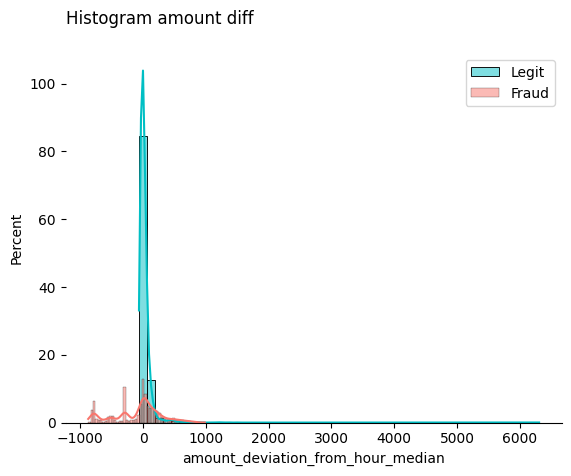

In [67]:
# plt.figure(figsize=(12, 8))
sns.histplot(data=dist_legit_df, x="amount_deviation_from_hour_median", color="#00BFC4", label="Legit", kde=True, bins=50, stat='percent')
sns.histplot(data=dist_fraud_df, x="amount_deviation_from_hour_median", color="#F8766D", label="Fraud", kde=True, bins=50, stat='percent')

plt.title("Histogram amount diff \n", loc = 'left')
# plt.gcf().set_dpi(130)
sns.despine( left=True)
plt.legend()
plt.show()

### Gender
Regarding gender, it was not possible to identify a significant pattern for frauds.

> However, valuable information for the business is that **male customers tend to spend higher amounts**, even when buying from the same categories. In this sense, they may be customers with a higher revenue generation potential.. In this sense, ***they may be customers with a higher revenue generation potential.***

Business Actions:
- Intensify campaigns for acquiring and activating male customers.

In [68]:
regular_df.gender.value_counts()/df.shape[0]

F    0.544568
M    0.449643
Name: gender, dtype: float64

In [69]:
fraud_df.gender.value_counts()/fraud_df.shape[0]

M    0.502398
F    0.497602
Name: gender, dtype: float64

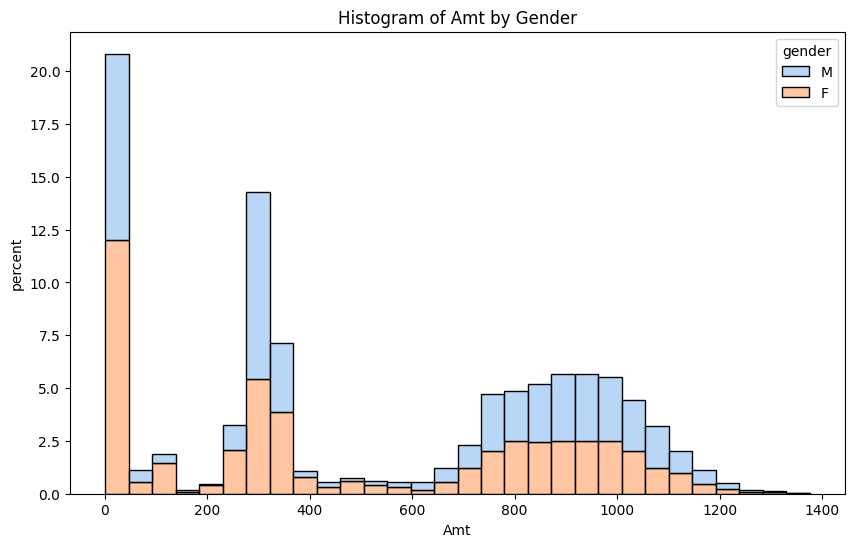

In [70]:
plt.figure(figsize=(10, 6))
sns.histplot(data=dist_fraud_df, x='amt', hue='gender', multiple='stack', palette='pastel', bins=30, stat='percent')
plt.title('Histogram of Amt by Gender')
plt.xlabel('Amt')
plt.ylabel('percent')
plt.show()

In [71]:
description_by_gender = fraud_df.groupby('gender')['amt'].describe(percentiles=[.25, .5, .75, .95])


In [72]:
description_by_gender

,count,mean,std,min,25%,50%,75%,95%,max
gender,,,,,,,,,
F,3735.0,494.052835,391.202030,1.91,51.03,350.75,873.74,1073.007,1376.04
M,3771.0,568.231575,386.447651,1.06,286.16,678.90,921.54,1093.010,1371.81


In [73]:
df_male = df[df['gender'] == 'M']
df_female = df[df['gender'] == 'F']

top_categories_male = df_male['category'].value_counts().nlargest(5)
top_categories_female = df_female['category'].value_counts().nlargest(5)

print("Top 5 Categories for Male:")
print(top_categories_male)

print("\nTop 5 Categories for Female:")
print(top_categories_female)

Top 5 Categories for Male:
gas_transport    58992
grocery_pos      58226
home             57836
kids_pets        50158
shopping_pos     48841
Name: category, dtype: int64

Top 5 Categories for Female:
gas_transport    72667
shopping_pos     67831
grocery_pos      65412
home             65279
kids_pets        62877
Name: category, dtype: int64


### Location

> The "location" variables, surprisingly, did not yield significant insights. The distance between the consumer and the merchant did not reveal differences between frauds and legitimate transactions, even when using two different types of distances. The state and region of the country followed the same trend.



#### Lat-Long Delta

In [74]:
fraud_amt_describe = fraud_df['lat_long_delta_merchant_customer'].describe(percentiles=[.25, .5, .75, .95]).round(2)
regular_amt_describe = regular_df['lat_long_delta_merchant_customer'].describe(percentiles=[.25, .5, .75, .95]).round(2)

fraud_amt_describe.loc['95%'] = fraud_df['lat_long_delta_merchant_customer'].quantile(0.95).round(2)
regular_amt_describe.loc['95%'] = regular_df['lat_long_delta_merchant_customer'].quantile(0.95).round(2)

combined_df = pd.concat([ regular_amt_describe,fraud_amt_describe,], axis=1)
combined_df.columns = ['Regular', 'Fraud']

print(combined_df)

          Regular    Fraud
count  1289169.00  7506.00
mean         0.77     0.77
std          0.28     0.28
min          0.00     0.01
25%          0.56     0.57
50%          0.80     0.80
75%          0.98     0.98
95%          1.20     1.20
max          1.41     1.40


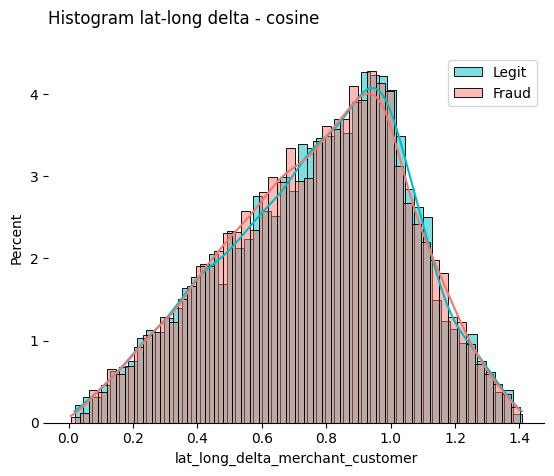

In [75]:
sns.histplot(data=dist_legit_df, x="lat_long_delta_merchant_customer", color="#00BFC4", label="Legit", kde=True, bins=50, stat='percent')
sns.histplot(data=dist_fraud_df, x="lat_long_delta_merchant_customer", color="#F8766D", label="Fraud", kde=True, bins=50, stat='percent')

plt.title("Histogram lat-long delta - cosine \n", loc = 'left')
sns.despine( left=True)
plt.legend()
plt.show()

In [76]:
def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # raio médio da Terra em quilômetros

    # Converte coordenadas de graus para radianos
    lat1, lon1, lat2, lon2 = np.radians([lat1, lon1, lat2, lon2])

    # Calcula diferenças de coordenadas
    dlat = lat2 - lat1
    dlon = lon2 - lon1

    # Calcula a fórmula de Haversine
    a = np.sin(dlat / 2) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2) ** 2
    c = 2 * np.arcsin(np.sqrt(a))

    # Distância em quilômetros
    distance = R * c
    return distance



In [77]:
dist_fraud_df['distance_H'] = haversine(dist_fraud_df['lat'], dist_fraud_df['long'], dist_fraud_df['merch_lat'], dist_fraud_df['merch_long'])
dist_legit_df['distance_H'] = haversine(dist_legit_df['lat'], dist_legit_df['long'], dist_legit_df['merch_lat'], dist_legit_df['merch_long'])


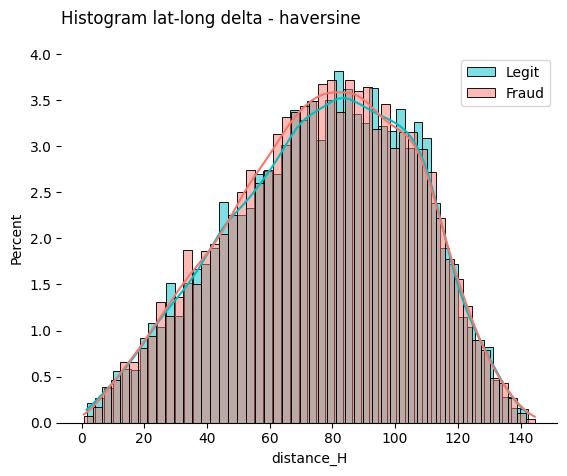

In [78]:
# plt.figure(figsize=(12, 8))
sns.histplot(data=dist_legit_df, x="distance_H", color="#00BFC4", label="Legit", kde=True, bins=50, stat='percent')
sns.histplot(data=dist_fraud_df, x="distance_H", color="#F8766D", label="Fraud", kde=True, bins=50, stat='percent')

plt.title("Histogram lat-long delta - haversine \n", loc = 'left')
# plt.gcf().set_dpi(130)
sns.despine( left=True)
plt.legend()
plt.show()

#### State

In [79]:
(regular_df.state.value_counts()/regular_df.shape[0]).head()

TX    0.073223
NY    0.064341
PA    0.061582
CA    0.043465
OH    0.035805
Name: state, dtype: float64

In [80]:
(fraud_df.state.value_counts()/fraud_df.shape[0]).head()

NY    0.073941
TX    0.063816
PA    0.061018
CA    0.043432
OH    0.042766
Name: state, dtype: float64

In [81]:
(regular_df.region.value_counts()/regular_df.shape[0]).head()

midwest      0.280872
Unknown      0.217463
northeast    0.188997
south        0.164172
west         0.148496
Name: region, dtype: float64

In [82]:
(fraud_df.region.value_counts()/fraud_df.shape[0])

midwest      0.282307
Unknown      0.199707
northeast    0.197309
south        0.173195
west         0.147482
Name: region, dtype: float64

### Correlation

No correlation surprised the results of the analysis.

<Figure size 1200x1500 with 0 Axes>

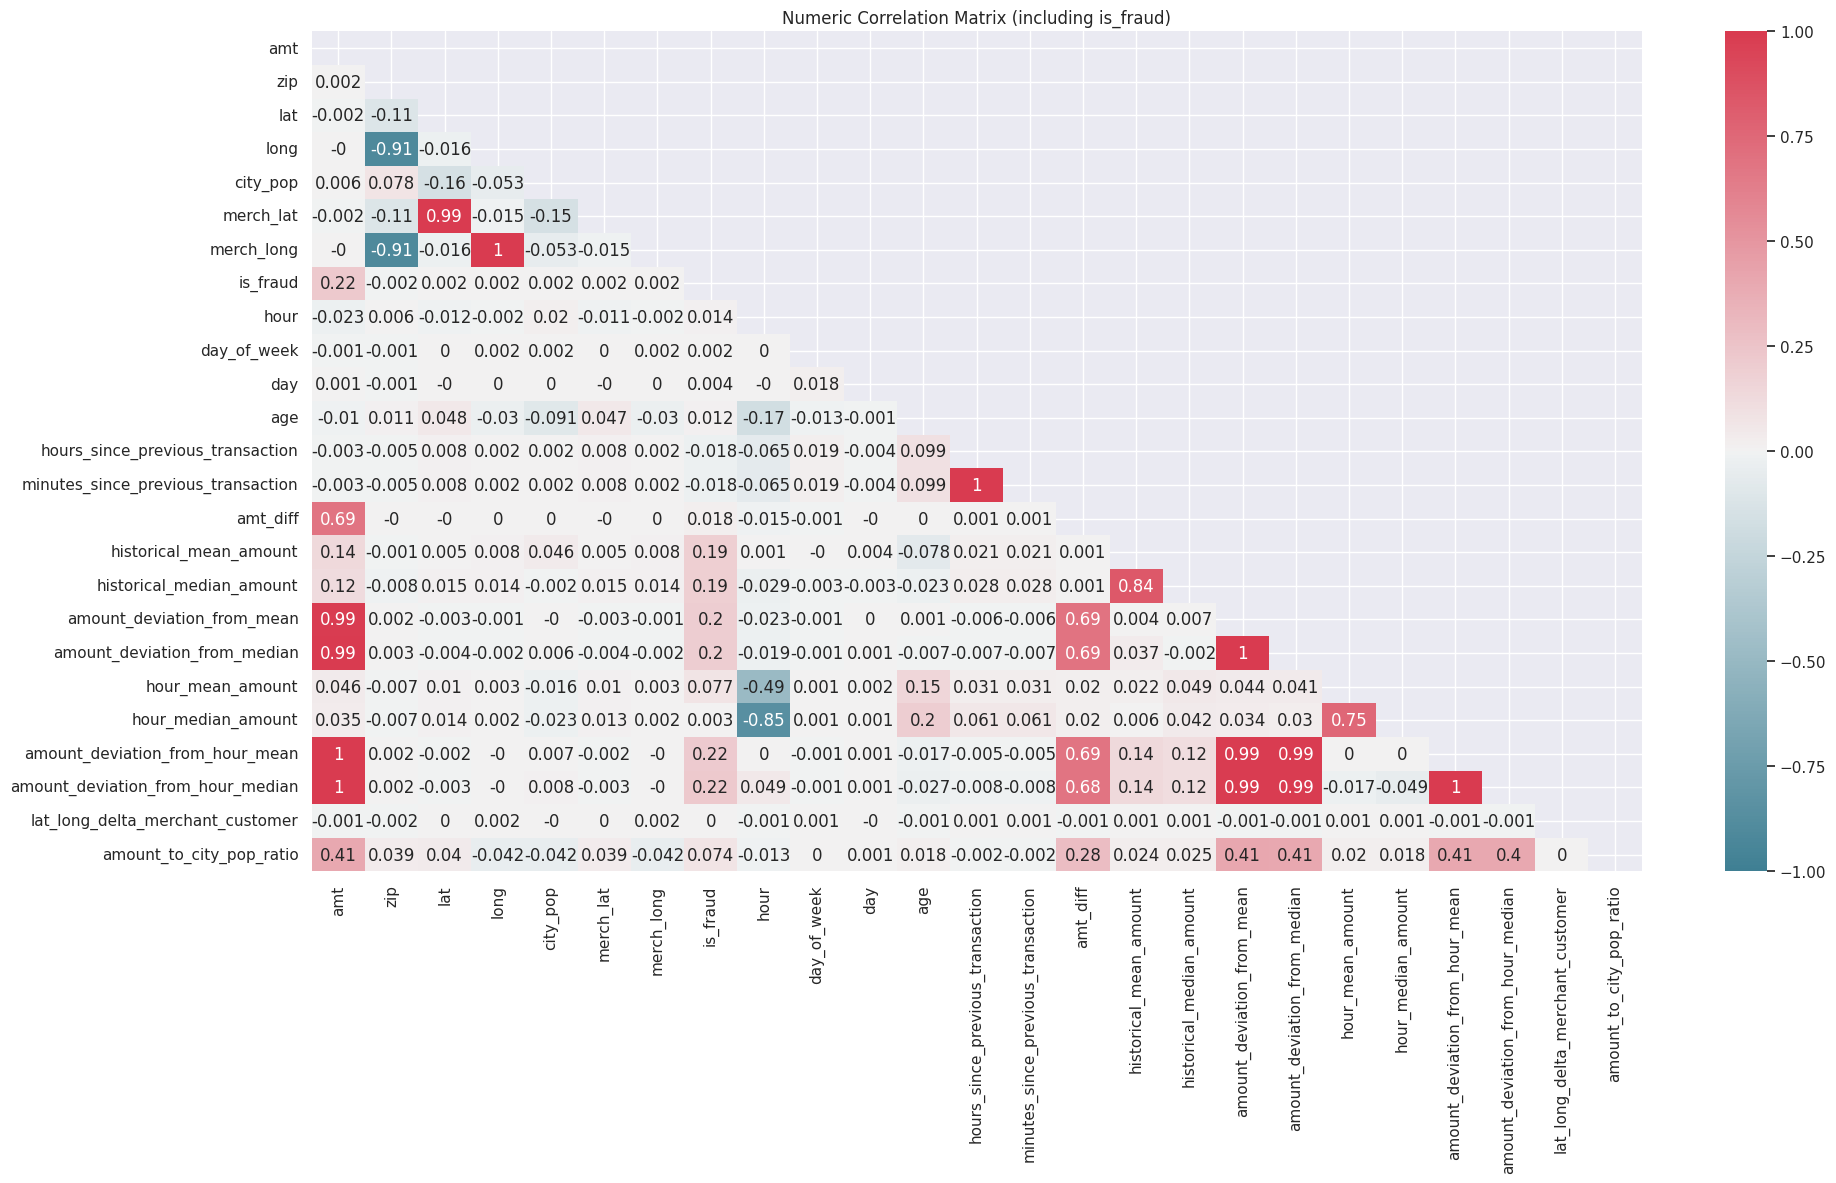

In [83]:
df_ = df.drop(['Unnamed: 0', 'cc_num', 'unix_time'], axis=1)

numeric_columns = df_.select_dtypes(include=np.number).columns

numeric_correlation_matrix = df_[numeric_columns].corr()

numeric_correlation_matrix = numeric_correlation_matrix.round(3)

mask = np.triu(np.ones_like(numeric_correlation_matrix, dtype=bool))

plt.figure(figsize=(12, 15))

sns.set(font_scale=1)
plt.figure(figsize=(20, 12))

sns.heatmap(numeric_correlation_matrix, annot=True, vmin=-1, vmax=1, center=0, cmap=sns.diverging_palette(220, 8, as_cmap=True), mask=mask)
plt.title('Numeric Correlation Matrix (including is_fraud)')

plt.tight_layout()
plt.show()


## Machine Learning Models

### Methodology

Process:
1. Feature selection
   - Only the most relevant features in the analysis.

2. Data transformation:
   - Categorical: One-hot encoding.
   - Numeric: Standard scaling.

3. Model selection criteria:
   - Historical performance according to the literature in this use case.
   - Robustness.
   - Ability to handle class imbalance.
   - Explainability.

4. Evaluation Criteria:
This is a highly complex topic, especially in this industry, with several questions to be addressed.
  - What are the consequences of each type of error?
  - What is the business priority?
  - List goes on and on

> For analysis purposes, we will use ***Recall, F1-score, and a proportional average of recall and precision***, in that order of priority. ***The intention is to minimize false negatives to the maximum extent. I am assuming that stakeholders prioritize this issue.*** Later on, we can analyze not only these metrics but also the financial aspect.

5. Model Training:
  - All models will be evaluated through cross-validation using the metrics mentioned earlier.

6. Model Testing and Avaliation:
  - All models will be tested, considering there are few, and the type of problem we are dealing with can be significantly affected by the bias and variance trade-off.


### Data Prep & Feature Engeneering

In [84]:
features = ['datetime','merchant', 'category', 'amt','gender','age','day', 'hour','minutes_since_previous_transaction','amt_diff',
'amount_deviation_from_mean','amount_deviation_from_median', 'amount_deviation_from_hour_mean',
'amount_deviation_from_hour_median', 'lat_long_delta_merchant_customer','region', 'amount_to_city_pop_ratio']

In [85]:
df = pd.read_csv("/content/drive/MyDrive/fincrime_ds/tr_fincrime_train.csv")

In [86]:
data_transformer = DataTransformer(df)

df = data_transformer.run_pipeline(df)

In [87]:
train_df_preprocessed, X_train, y_train = preprocess_train_data(df, features)

### Training

> **The ensemble models performed the best across all metrics (Random Forest, XGBoost)**. Although the four models showed very good and similar performance.

> Logistic regression had the worst overall performance, especially in the main evaluation metric, Recall.

> The decision tree also deserves attention due to ***performance very similar to ensemble models but with greater explainability***, which, depending on the situation, can be a critical factor.

In [88]:
# Define the models
seed = 42
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=seed),
    'Random Forest': RandomForestClassifier(random_state=seed),
    'XGBoost': XGBClassifier(seed=seed),  # Use the 'seed' parameter for XGBoost
    'Decision Tree': DecisionTreeClassifier(random_state=seed)
}

# Define custom scoring function for composite score
def composite_score(y_true, y_pred):
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    return 0.7 * recall + 0.3 * precision

# Dictionary to store precision, recall, and composite scores for each model
precision_scores = {}
recall_scores = {}
composite_scores = {}

# Iterate over the models
for model_name, model in models.items():

    print(f"training {model_name}\n")
    # Perform cross-validation
    y_pred = cross_val_predict(model, X_train, y_train, cv=5)

    # Calculate precision, recall, and confusion matrix
    precision = precision_score(y_train, y_pred)
    recall = recall_score(y_train, y_pred)

    # Store precision and recall scores
    precision_scores[model_name] = precision
    recall_scores[model_name] = recall

    # Calculate composite score
    composite = composite_score(y_train, y_pred)
    composite_scores[model_name] = composite

# Print precision, recall, and composite scores
print("Precision Scores:")
for model_name, precision in sorted(precision_scores.items(), key=lambda x: x[1], reverse=True):
    print(f"{model_name}: {precision:.4f}")

print("\nRecall Scores:")
for model_name, recall in sorted(recall_scores.items(), key=lambda x: x[1], reverse=True):
    print(f"{model_name}: {recall:.4f}")

print("\nComposite Scores:")
for model_name, composite in sorted(composite_scores.items(), key=lambda x: x[1], reverse=True):
    print(f"{model_name}: {composite:.4f}")


training Logistic Regression

training Random Forest

training XGBoost

training Decision Tree

Precision Scores:
XGBoost: 0.9873
Random Forest: 0.9843
Decision Tree: 0.9756
Logistic Regression: 0.9401

Recall Scores:
XGBoost: 0.9853
Random Forest: 0.9760
Decision Tree: 0.9734
Logistic Regression: 0.8572

Composite Scores:
XGBoost: 0.9859
Random Forest: 0.9785
Decision Tree: 0.9740
Logistic Regression: 0.8821


### Profit Analysis

While reference metrics provide valuable insights into a model's performance, they have a significant drawback: ***they do not measure business success.***

However, we can utilize the concept of expected value to calculate ***the expected profit of the model***. The idea is that with each prediction, an action within the operation is executed that can generate revenue, prevent losses, or incur costs.

To perform this calculation, a profound understanding of the business and studies quantifying these consequences in monetary terms would be necessary. Due to time constraints and the lack of detailed business information, *I will illustrate this evaluation model in a simplified manner using arbitrary values.*

For this case, I will make the following assumptions:

1. Every fraud prediction results in blocking the customer's card, which generates friction and erodes the relationship.
2. The average customer lifetime is four years.
3. When a customer experiences an unidentified fraud, they lose trust in the bank.
4. Incorrect blocking leads the customer to transact only half of their usual volume since trust is lost.
5. Revenue is based on a 3% fee received by the bank for the transaction amount.

With these assumptions:

- Benefit of True Positive: An increase in trust, leading to a 20% increase in transaction volume.

- Cost of False Positive: A halving of transaction volume.

- Cost of False Negative: Loss of the customer's lifetime value (LTV).

*Note: The reference value for annual transaction volume will be the median per customer in 2019, the year for which we have all the information.*


In [89]:
test_set_clean = df[df['datetime'].dt.year == 2019]

total_amount_per_customer = test_set_clean.groupby('cc_num')['amt'].sum().reset_index()

df_total_amount = pd.DataFrame({
    'cc_num': total_amount_per_customer['cc_num'],
    'total_amount': total_amount_per_customer['amt']
})

median_amt = df_total_amount["total_amount"].median()

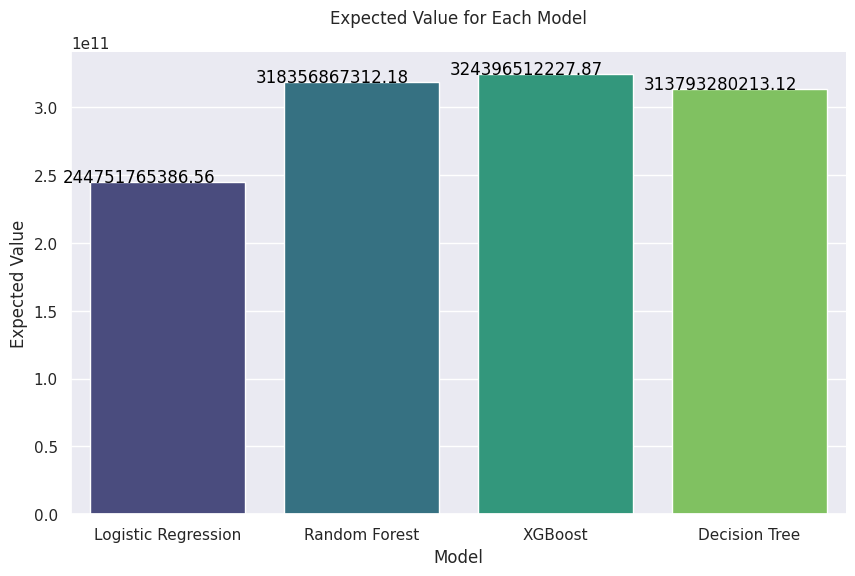

In [90]:
from sklearn.model_selection import train_test_split

# Dictionary to store the expected value of each model
expected_values = {}

# Define X (features) and y (target variable)
X = train_df_preprocessed.drop("is_fraud", axis=1)  # All columns except the target variable
y = train_df_preprocessed["is_fraud"]  # Only the target variable

# Separate the data into training and test sets (70% training, 30% test)
pX_train, pX_test, py_train, py_test = train_test_split(X_train, y_train, test_size=0.3, random_state=42)

# Iterating over the models
for model_name, model in models.items():
    model.fit(pX_train, py_train)
    y_pred = model.predict(pX_test)

    # Calculating the expected value
    VP = sum((py_test == 1) & (y_pred == 1))
    VN = sum((py_test == 0) & (y_pred == 0))
    FP = sum((py_test == 0) & (y_pred == 1))
    FN = sum((py_test == 1) & (y_pred == 0))

    # Benefit per identified fraudulent transaction - the value of the identified transaction + 20% of the annual credit card spending in 2020
    benefit_vp = pX_test[(py_test == 1) & (y_pred == 1)].shape[0] * median_amt + ((median_amt * 0.2) * 0.03)
    cost_fp = (median_amt / 2) * 0.03  # False positive cost - predicted fraud but not
    cost_fn = 4 * median_amt * 0.33  # False negative cost - predicted legitimate but fraud

    expected_value = (VP * benefit_vp) + (VN * 0) - (FP * cost_fp) - (FN * cost_fn)
    expected_values[model_name] = expected_value

# Round values to two decimal places
expected_values = {key: round(value, 2) for key, value in expected_values.items()}

# Plotting using Seaborn for better aesthetics
plt.figure(figsize=(10, 6))
bars = sns.barplot(x=list(expected_values.keys()), y=list(expected_values.values()), palette="viridis")

plt.xlabel('Model')
plt.ylabel('Expected Value')
plt.title('Expected Value for Each Model\n')


# Adding labels to the bars
for bar, value in zip(bars.patches, expected_values.values()):
    plt.text(bar.get_x() + bar.get_width() / 2 - 0.15, bar.get_height() + 0.1, f'{value:.2f}', ha='center', color='black')

# Remove the right and top spines for better aesthetics
sns.despine()

plt.show()



**It became evident with this decision model that logistic regression is performing much worse than the other models.**

### Testing

#### Data Prep

In [91]:
test_set = pd.read_csv('/content/drive/MyDrive/fincrime_ds/tr_fincrime_test.csv')

In [92]:
data_transformer = DataTransformer(test_set)
test_set = data_transformer.run_pipeline(test_set)


In [93]:
test_set_clean, X, y = preprocess_test_data(df, features, x_train_processed = X_train)

<ipython-input-11-e263bfab29bc>:110: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.loc[:, numeric_features] = numeric_imputer.fit_transform(X.loc[:, numeric_features])
<ipython-input-11-e263bfab29bc>:110: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  X.loc[:, numeric_features] = numeric_imputer.fit_transform(X.loc[:, numeric_features])
<ipython-input-11-e263bfab29bc>:114: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See

### Test Results

The results have significantly dropped between the training and test sets. Something might have happened with the data or there is overfitting in the model.

Perhaps there is an issue with sampling.

I couldn't identify any errors in the data processing. I will try to improve the parameters.

----------------------------Logistic Regression----------------------------
              precision    recall  f1-score   support

           0     0.9992    0.9453    0.9715   1289169
           1     0.0847    0.8696    0.1544      7506

    accuracy                         0.9449   1296675
   macro avg     0.5420    0.9074    0.5629   1296675
weighted avg     0.9939    0.9449    0.9668   1296675

AUC: 0.9074



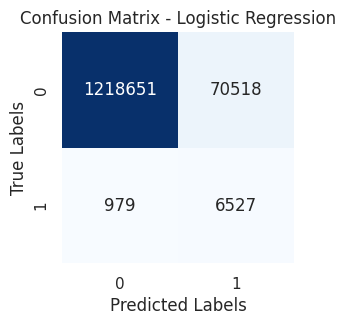

----------------------------Random Forest----------------------------
              precision    recall  f1-score   support

           0     1.0000    0.9840    0.9919   1289169
           1     0.2657    0.9964    0.4195      7506

    accuracy                         0.9840   1296675
   macro avg     0.6328    0.9902    0.7057   1296675
weighted avg     0.9957    0.9840    0.9886   1296675

AUC: 0.9902



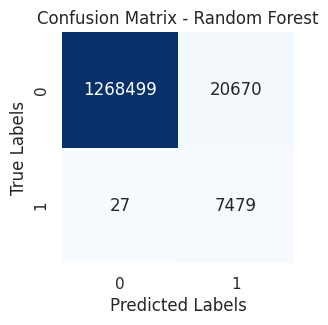

----------------------------XGBoost----------------------------
              precision    recall  f1-score   support

           0     1.0000    0.9859    0.9929   1289169
           1     0.2921    0.9963    0.4518      7506

    accuracy                         0.9860   1296675
   macro avg     0.6461    0.9911    0.7224   1296675
weighted avg     0.9959    0.9860    0.9898   1296675

AUC: 0.9911



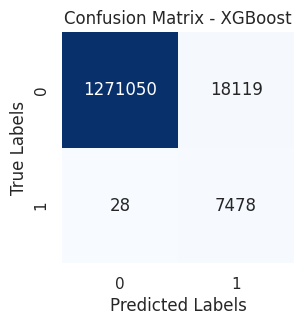

----------------------------Decision Tree----------------------------
              precision    recall  f1-score   support

           0     0.9999    0.9733    0.9865   1289169
           1     0.1776    0.9888    0.3011      7506

    accuracy                         0.9734   1296675
   macro avg     0.5888    0.9811    0.6438   1296675
weighted avg     0.9952    0.9734    0.9825   1296675

AUC: 0.9811



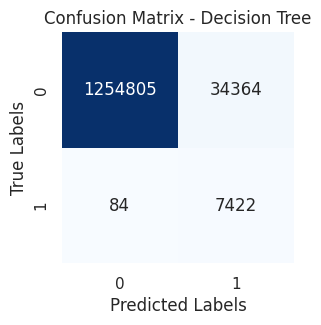

In [94]:
for model_name, model in models.items():
    print(f"----------------------------{model_name}----------------------------")

    model.fit(X_train, y_train)

    yhat = model.predict(X)

    print(classification_report(y, yhat, digits=4))

    print("AUC: {:.4f}\n".format(roc_auc_score(y, yhat)))

    cm = confusion_matrix(y, yhat)

    plt.figure(figsize=(3, 3))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.title(f"Confusion Matrix - {model_name}")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.show()



## Param Tunning

I opted to use Random Search because other methods, such as Bayesian learning, were taking too long to execute.

Additionally, Random Search is considered one of the best techniques.

In [95]:
import numpy as np
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import make_scorer, recall_score, f1_score

def custom_scorer(y_true, y_pred):
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    return (recall + f1) / 2

# XGBoost
xgb_params = {
    'learning_rate': [0.01, 0.1, 0.2, 0.3],
    'max_depth': np.arange(3, 10),
    'n_estimators': np.arange(50, 200, 10),
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
}

xgb_model = XGBClassifier(objective='binary:logistic', random_state=42)
xgb_random = RandomizedSearchCV(xgb_model, xgb_params, n_iter=50, scoring=make_scorer(custom_scorer), cv=3, random_state=42)
xgb_random.fit(X_train, y_train)

print("Best XGBoost parameters:", xgb_random.best_params_)
print("Best XGBoost Recall and F1-score:", xgb_random.best_score_)

# Random Forest
rf_params = {
    'n_estimators': np.arange(50, 200, 10),
    'criterion': ['gini', 'entropy'],
    'max_depth': np.arange(3, 10),
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', None],
}

rf_model = RandomForestClassifier(random_state=42)
rf_random = RandomizedSearchCV(rf_model, rf_params, n_iter=50, scoring=make_scorer(custom_scorer), cv=3, random_state=42)
rf_random.fit(X_train, y_train)

print("Best Random Forest parameters:", rf_random.best_params_)
print("Best Random Forest Recall and F1-score:", rf_random.best_score_)

xgb_test_pred = xgb_random.best_estimator_.predict(X)
rf_test_pred = rf_random.best_estimator_.predict(X)

print("XGBoost Recall:", recall_score(y, xgb_test_pred))
print("XGBoost F1-score:", f1_score(y, xgb_test_pred))

print("Random Forest Recall:", recall_score(y, rf_test_pred))
print("Random Forest F1-score:", f1_score(y, rf_test_pred))


Best XGBoost parameters: {'subsample': 0.9, 'n_estimators': 190, 'max_depth': 7, 'learning_rate': 0.1, 'colsample_bytree': 1.0}
Best XGBoost Recall and F1-score: 0.985499618791048
Best Random Forest parameters: {'n_estimators': 90, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': None, 'max_depth': 9, 'criterion': 'gini'}
Best Random Forest Recall and F1-score: 0.9738379672452729
XGBoost Recall: 0.9965361044497735
XGBoost F1-score: 0.4575623183973085
Random Forest Recall: 0.9762856381561418
Random Forest F1-score: 0.32284782800246714


## What would I do if I had more time and more data?


---


**Regarding the model**

> Given that the model performed exceptionally well in training using cross-validation, the substantial drop in performance is quite atypical. In this context, it could be either a data processing and engineering issue or overfitting. I would adopt a more data-centric approach, and if that proves ineffective, shift to a model-centric one.

**Conduct a peer review of the data processing and test data**

> It's possible that I might have overlooked some details that altered the data distribution, making it significantly different from the training set.

> Analyze whether a substantial difference exists between the training and testing datasets.

**Explore alternative sampling methods**

> SMOTE

> Utilize an imbalanced scenario for training.

**Attempt to find better parameters through other means**

> Experiment with Bayesian Optimizers like Optuna *(I attempted to use it, but the execution time was too long, even with Colab Pro)*.

> Test decision threshold optimization with values different from 0.5.
Explore other robust models such as neural networks.

**Other Model Complements**

> Utilize Expected Profit to optimize parameters.

> Implement a prediction API with FastAPI.

**In terms of analysis**

> Introduce hypothesis testing in comparisons of fraudulent and legitimate distributions to provide stronger statistical evidence.

> Investigate further into the high incidence of fraud victims in the dataset.

> Create a dashboard with visualizations using a BI tool or Streamlit.

**Regarding the code**

> Encapsulate some visualizations and comparative descriptive statistics within the visualization class.

> Establish a Git repository for those who want to run the code locally with greater ease.